# Classifying Guitar Note Sounds using Deep Learning

I could take a guitar class for beginners to understand what a note is and which fret it is located on. I found a way to make it simple.

### Guitar for Dummies

For this project, I will use a dataset made by me. The dataset contains 720 sound files of guitar notes and CSV file has file names and labels.

I used my acoustic guitar to build this dataset. The notes were played by guitar picks on open strings, and on the 1st-3th frets on every string. The notes were recorded and labeled by me using an IOS app called Hokusai 2. That's why the quality of the notes are okay. Also, the guitar was always in standard tuning. I used the GuitarTuner app to tune the Guitar.

### Audio sample file data overview

These sound files are digital audio files in .wav format (44.1 k - 32 bit).

Sound waves are digitised by sampling them at discrete intervals known as the sampling rate (typically 44.1kHz meaning samples are taken 44,100 times per second).

Each sample is the amplitude of the wave at a particular time interval, where the bit depth determines how detailed the sample will be also known as the dynamic range of the signal.

Therefore, the data we will be analysing for each sound file is essentially a one dimensional array or vector of amplitude values.

## Data Exploration and Visualisation

We will load a sample from each class and visually inspect the data for any patterns. So, I need to write some functions to display the plots. 

In [1]:
# Load imports

from tqdm import tqdm

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from scipy.io import wavfile

from python_speech_features import mfcc, logfbank

from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM

from keras.layers import Dropout, Dense, TimeDistributed

from keras.models import Sequential

from sklearn.utils.class_weight import compute_class_weight

import librosa

import IPython.display as ipd

import librosa.display

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer

from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import ModelCheckpoint

from keras.models import load_model

import pickle

from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
# Loading the CSV file into a Panda dataframe

df = pd.read_csv('guitar-sound.csv')

df.head()

fname   label position
0  E2-0th-myguitar-1.wav  E2-0th    6th-0
1  E2-0th-myguitar-2.wav  E2-0th    6th-0
2  E2-0th-myguitar-3.wav  E2-0th    6th-0
3  E2-0th-myguitar-4.wav  E2-0th    6th-0
4  E2-0th-myguitar-5.wav  E2-0th    6th-0

In [3]:
# serializing dataframe "df" to a file for Flask App

pickle.dump(df, open("Pickles/df.pkl", "wb"))

In [4]:
# Set 'fname' column as index column

df.set_index('fname', inplace =True)

df.head()

label position
fname                                 
E2-0th-myguitar-1.wav  E2-0th    6th-0
E2-0th-myguitar-2.wav  E2-0th    6th-0
E2-0th-myguitar-3.wav  E2-0th    6th-0
E2-0th-myguitar-4.wav  E2-0th    6th-0
E2-0th-myguitar-5.wav  E2-0th    6th-0

In [5]:
# Create a new column "length"

for f in df.index:
    
    rate, signal = wavfile.read('Data-raw/'+f)
    
    df.at[f, 'length'] = signal.shape[0]/rate

C:\Users\User\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


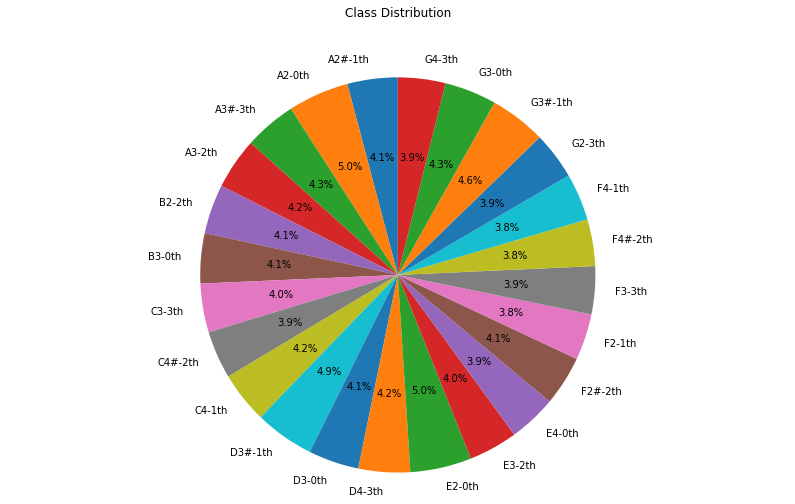

In [6]:
# Class Distribution for each note

classes = list(np.unique(df.label))

class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots(figsize=(14,8))

ax.set_title('Class Distribution', y = 1.08)

ax.pie(class_dist, labels = class_dist.index, autopct = '%1.1f%%', shadow = False, startangle = 90)

ax.axis('equal')

plt.show()

In [7]:
# Various values for plotting

signals = {}

fft = {}

fbank = {}

mfccs = {}

In [8]:
# Function to calculate fft values

def calc_fft(y, rate):
    
    n = len(y)
    
    freq = np.fft.rfftfreq(n, d=1/rate)
    
    Y = abs(np.fft.rfft(y)/n)
    
    return (Y, freq)

In [9]:
# Function to clean "noise" in sound file

def envelope(y, rate, threshold):
    
    mask = []
    
    y = pd.Series(y).apply(np.abs)
    
    y_mean = y.rolling(window = int(rate/10), min_periods = 1, center = True).mean()
    
    for mean in y_mean:
        
        if mean > threshold:
            
            mask.append(True)
            
        else:
            
            mask.append(False)
            
    return mask  

In [10]:
# Reset dataframe index

df.reset_index(inplace=True)

df.head()

fname   label position    length
0  E2-0th-myguitar-1.wav  E2-0th    6th-0  9.226667
1  E2-0th-myguitar-2.wav  E2-0th    6th-0  6.128005
2  E2-0th-myguitar-3.wav  E2-0th    6th-0  7.050658
3  E2-0th-myguitar-4.wav  E2-0th    6th-0  7.226667
4  E2-0th-myguitar-5.wav  E2-0th    6th-0  8.458662

In [11]:
# Create a function to calculate "fft", "fbank", and "mfccs" values

for c in classes:
    
    wav_file = df[df.label == c].iloc[0,0]
    
    signal, rate = librosa.load('Data-raw/'+ wav_file, sr = 44100)
    
    signals[c] = signal
    
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft = 1103).T
    
    fbank[c] = bank
    
    mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft = 1103).T
    
    mfccs[c] = mel

Now, we are ready to visualize sample datas

In [12]:
# Function to plot "Time Series"

def plot_signals(signals):
    
    fig, axes = plt.subplots(nrows=6, ncols=3, sharex=False,
                             sharey=True, figsize=(40,25))
    
    fig.suptitle('Time Series', size=16)
    
    i = 0
    
    for x in range(6):
        
        for y in range(3):
            
            axes[x,y].set_title(list(signals.keys())[i])
            
            axes[x,y].plot(list(signals.values())[i])
            
            axes[x,y].get_xaxis().set_visible(True)
            
            axes[x,y].get_yaxis().set_visible(True)
            
            i += 1

In [13]:
# Function to plot "Fourier Transforms"

def plot_fft(fft):
    
    fig, axes = plt.subplots(nrows=6, ncols=3, sharex=False,
                             sharey=True, figsize=(40,25))
    
    fig.suptitle('Fourier Transforms', size=16)
    
    i = 0
    
    for x in range(6):
        
        for y in range(3):
            
            data = list(fft.values())[i]
            
            Y, freq = data[0], data[1]
            
            axes[x,y].set_title(list(fft.keys())[i])
            
            axes[x,y].plot(freq, Y)
            
            axes[x,y].get_xaxis().set_visible(True)
            
            axes[x,y].get_yaxis().set_visible(True)
            
            i += 1

In [14]:
# Function to plot "Filter Bank Coefficients"

def plot_fbank(fbank):
    
    fig, axes = plt.subplots(nrows=6, ncols=3, sharex=False,
                             sharey=True, figsize=(40,25))
    
    fig.suptitle('Filter Bank Coefficients', size=16)
    
    i = 0
    
    for x in range(6):
        
        for y in range(3):
            
            axes[x,y].set_title(list(fbank.keys())[i])
            
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            
            axes[x,y].get_xaxis().set_visible(True)
            
            axes[x,y].get_yaxis().set_visible(True)
            
            i += 1

In [15]:
# Function to plot "Mel Frequency Cepstrum Coefficients"

def plot_mfccs(mfccs):
    
    fig, axes = plt.subplots(nrows=6, ncols=3, sharex=False,
                             sharey=True, figsize=(40,25))
    
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    
    i = 0
    
    for x in range(6):
        
        for y in range(3):
            
            axes[x,y].set_title(list(mfccs.keys())[i])
            
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            
            axes[x,y].get_xaxis().set_visible(True)
            
            axes[x,y].get_yaxis().set_visible(True)
            
            i += 1

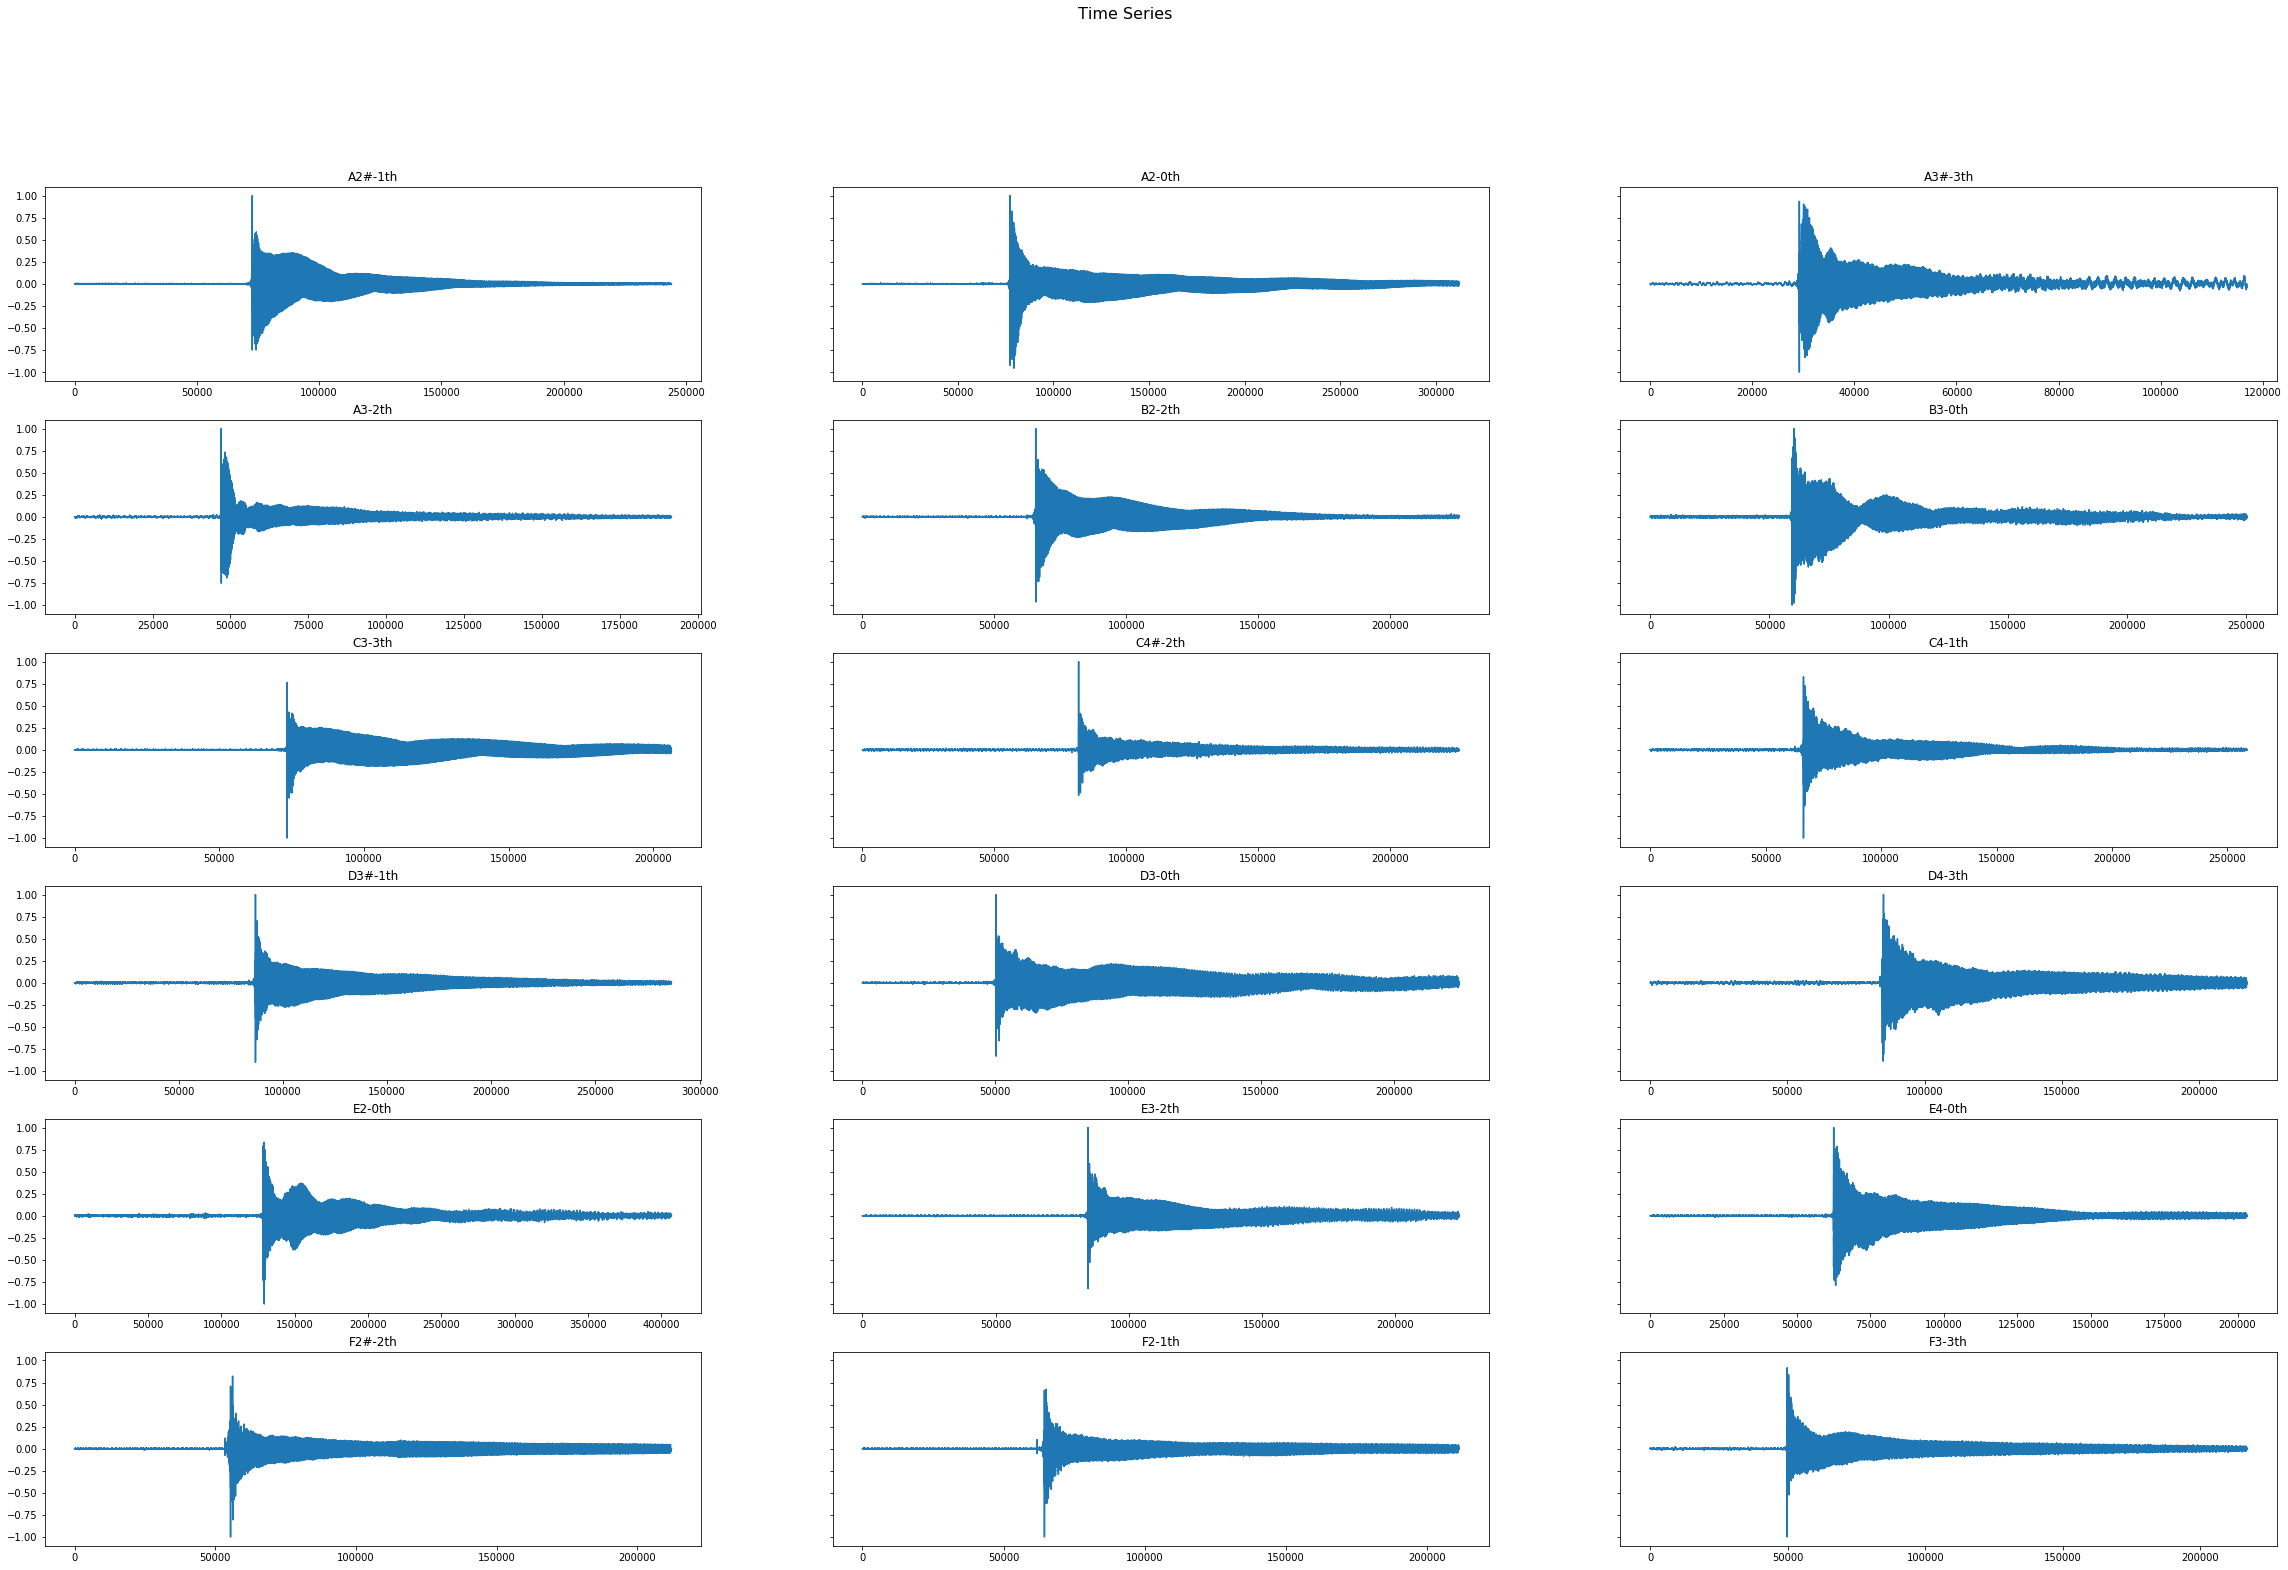

In [16]:
# Time Series

plot_signals(signals)

plt.show()

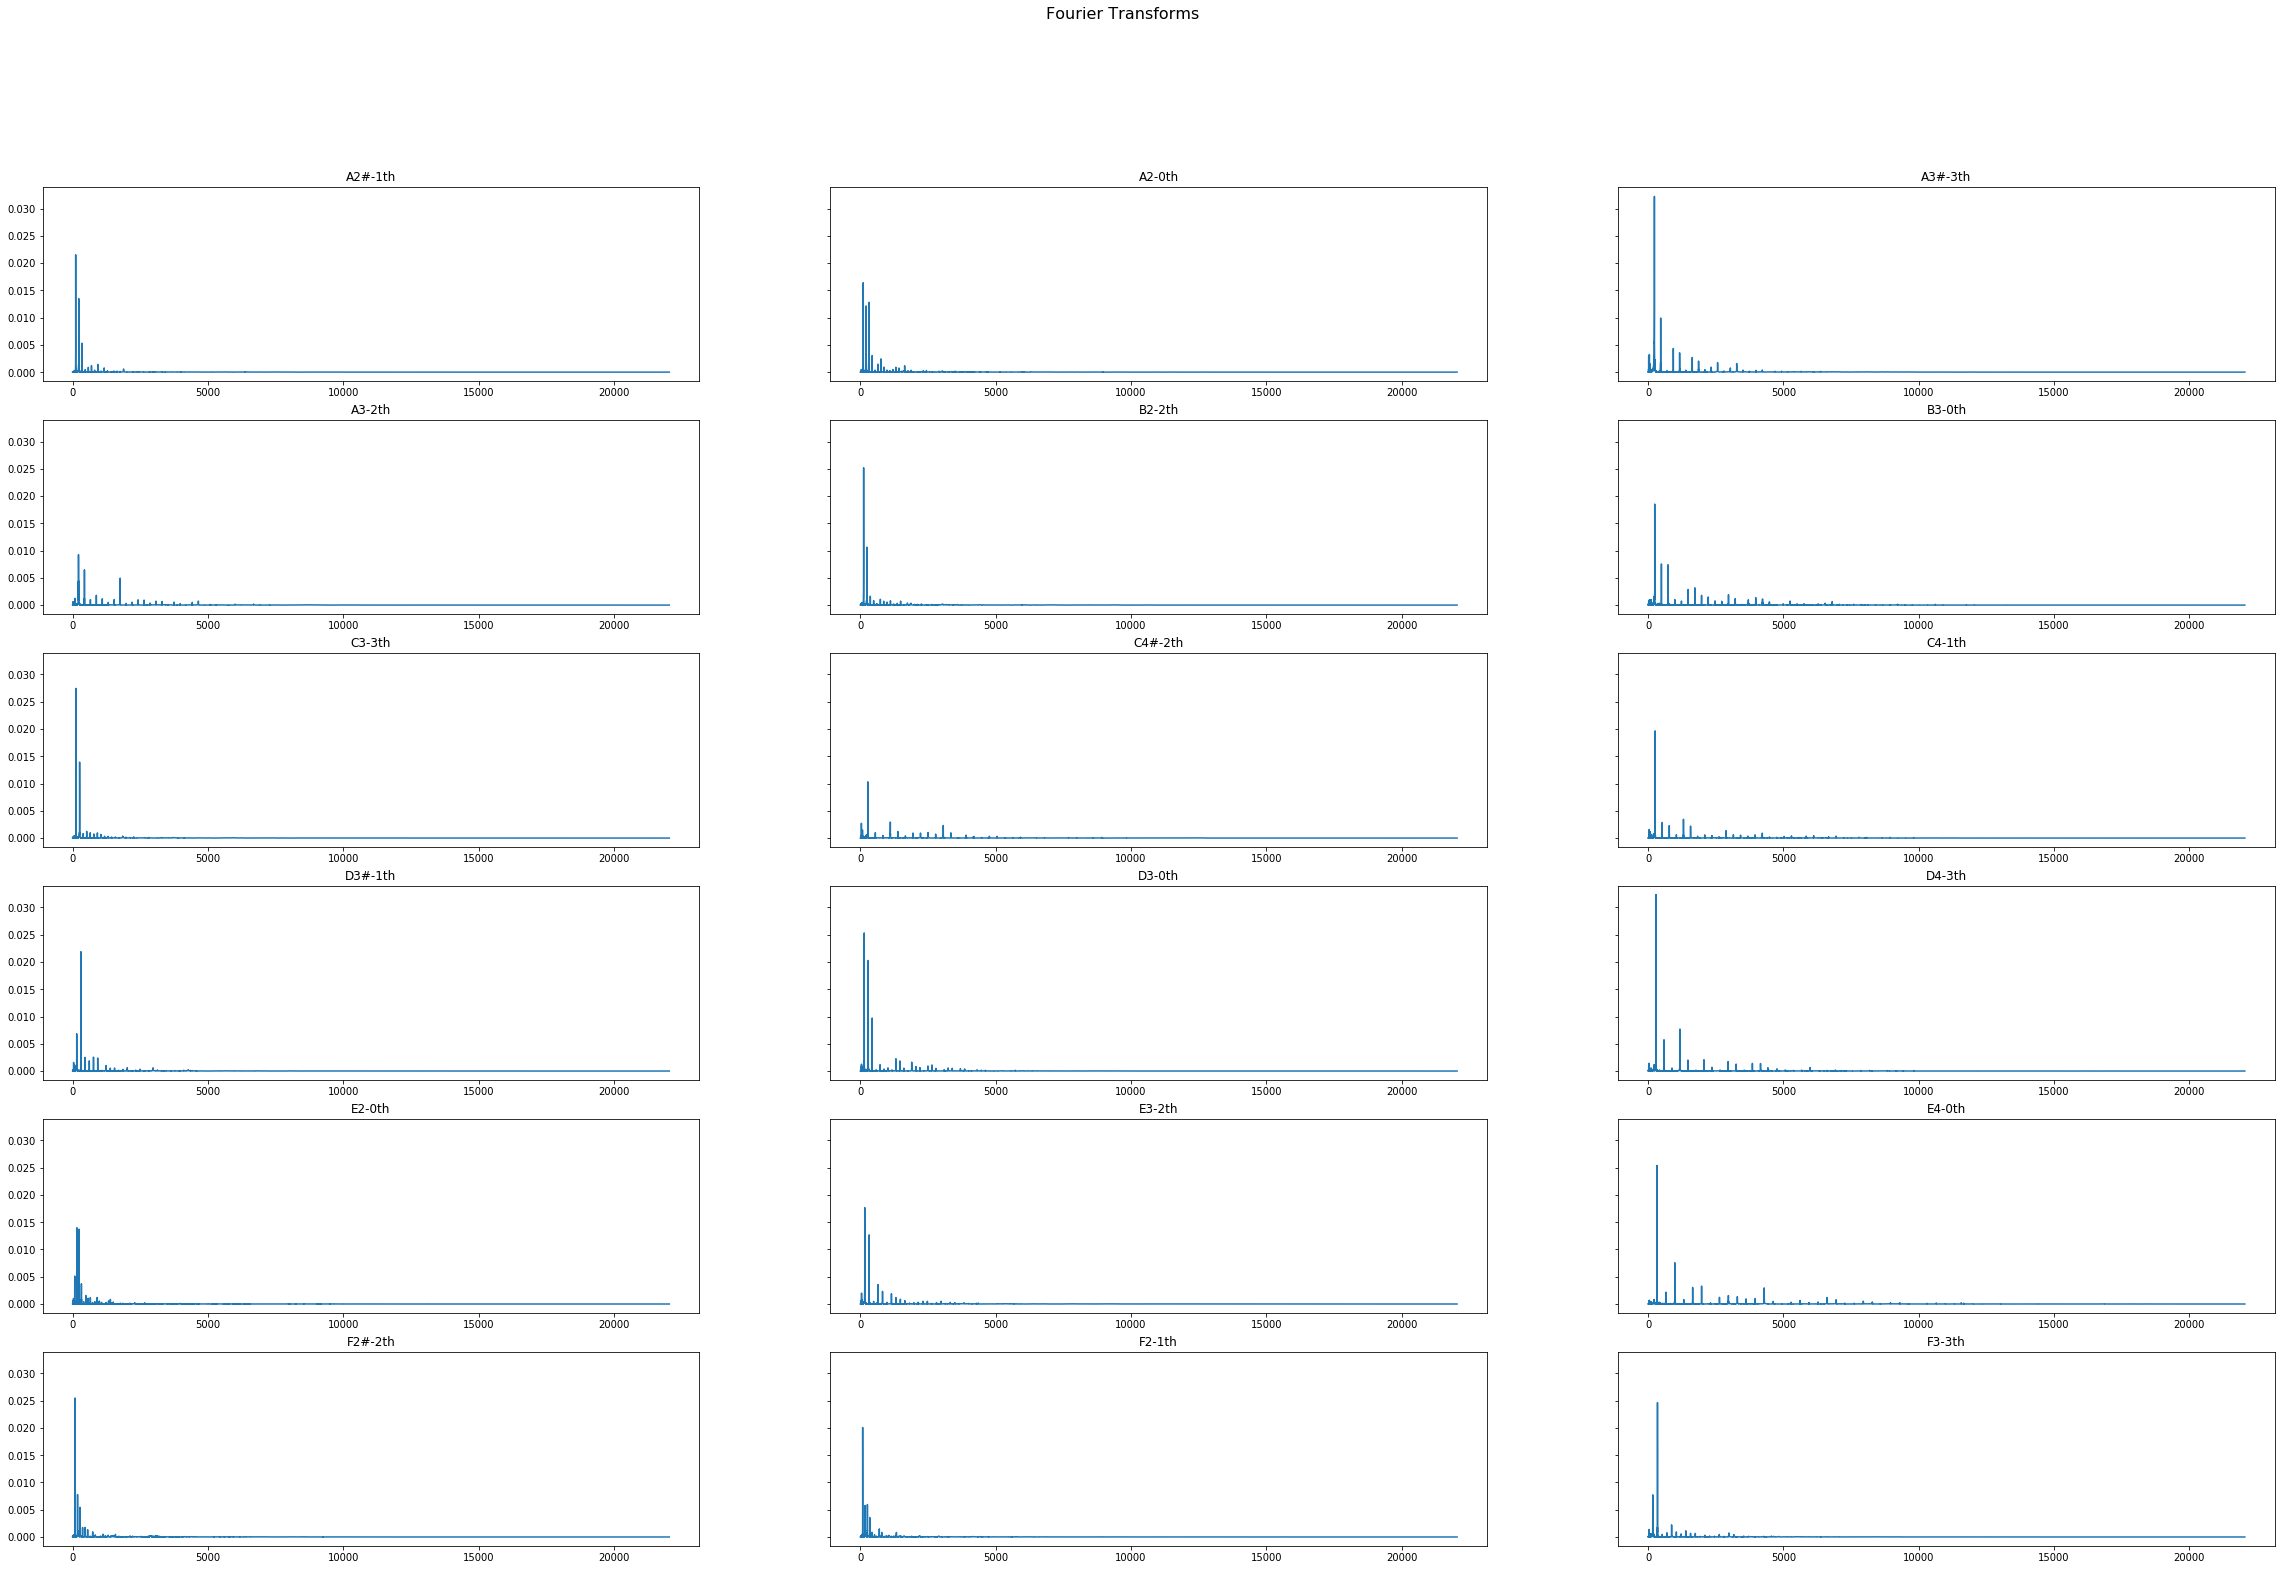

In [17]:
# Fast Fourier Transforms

plot_fft(fft)

plt.show()

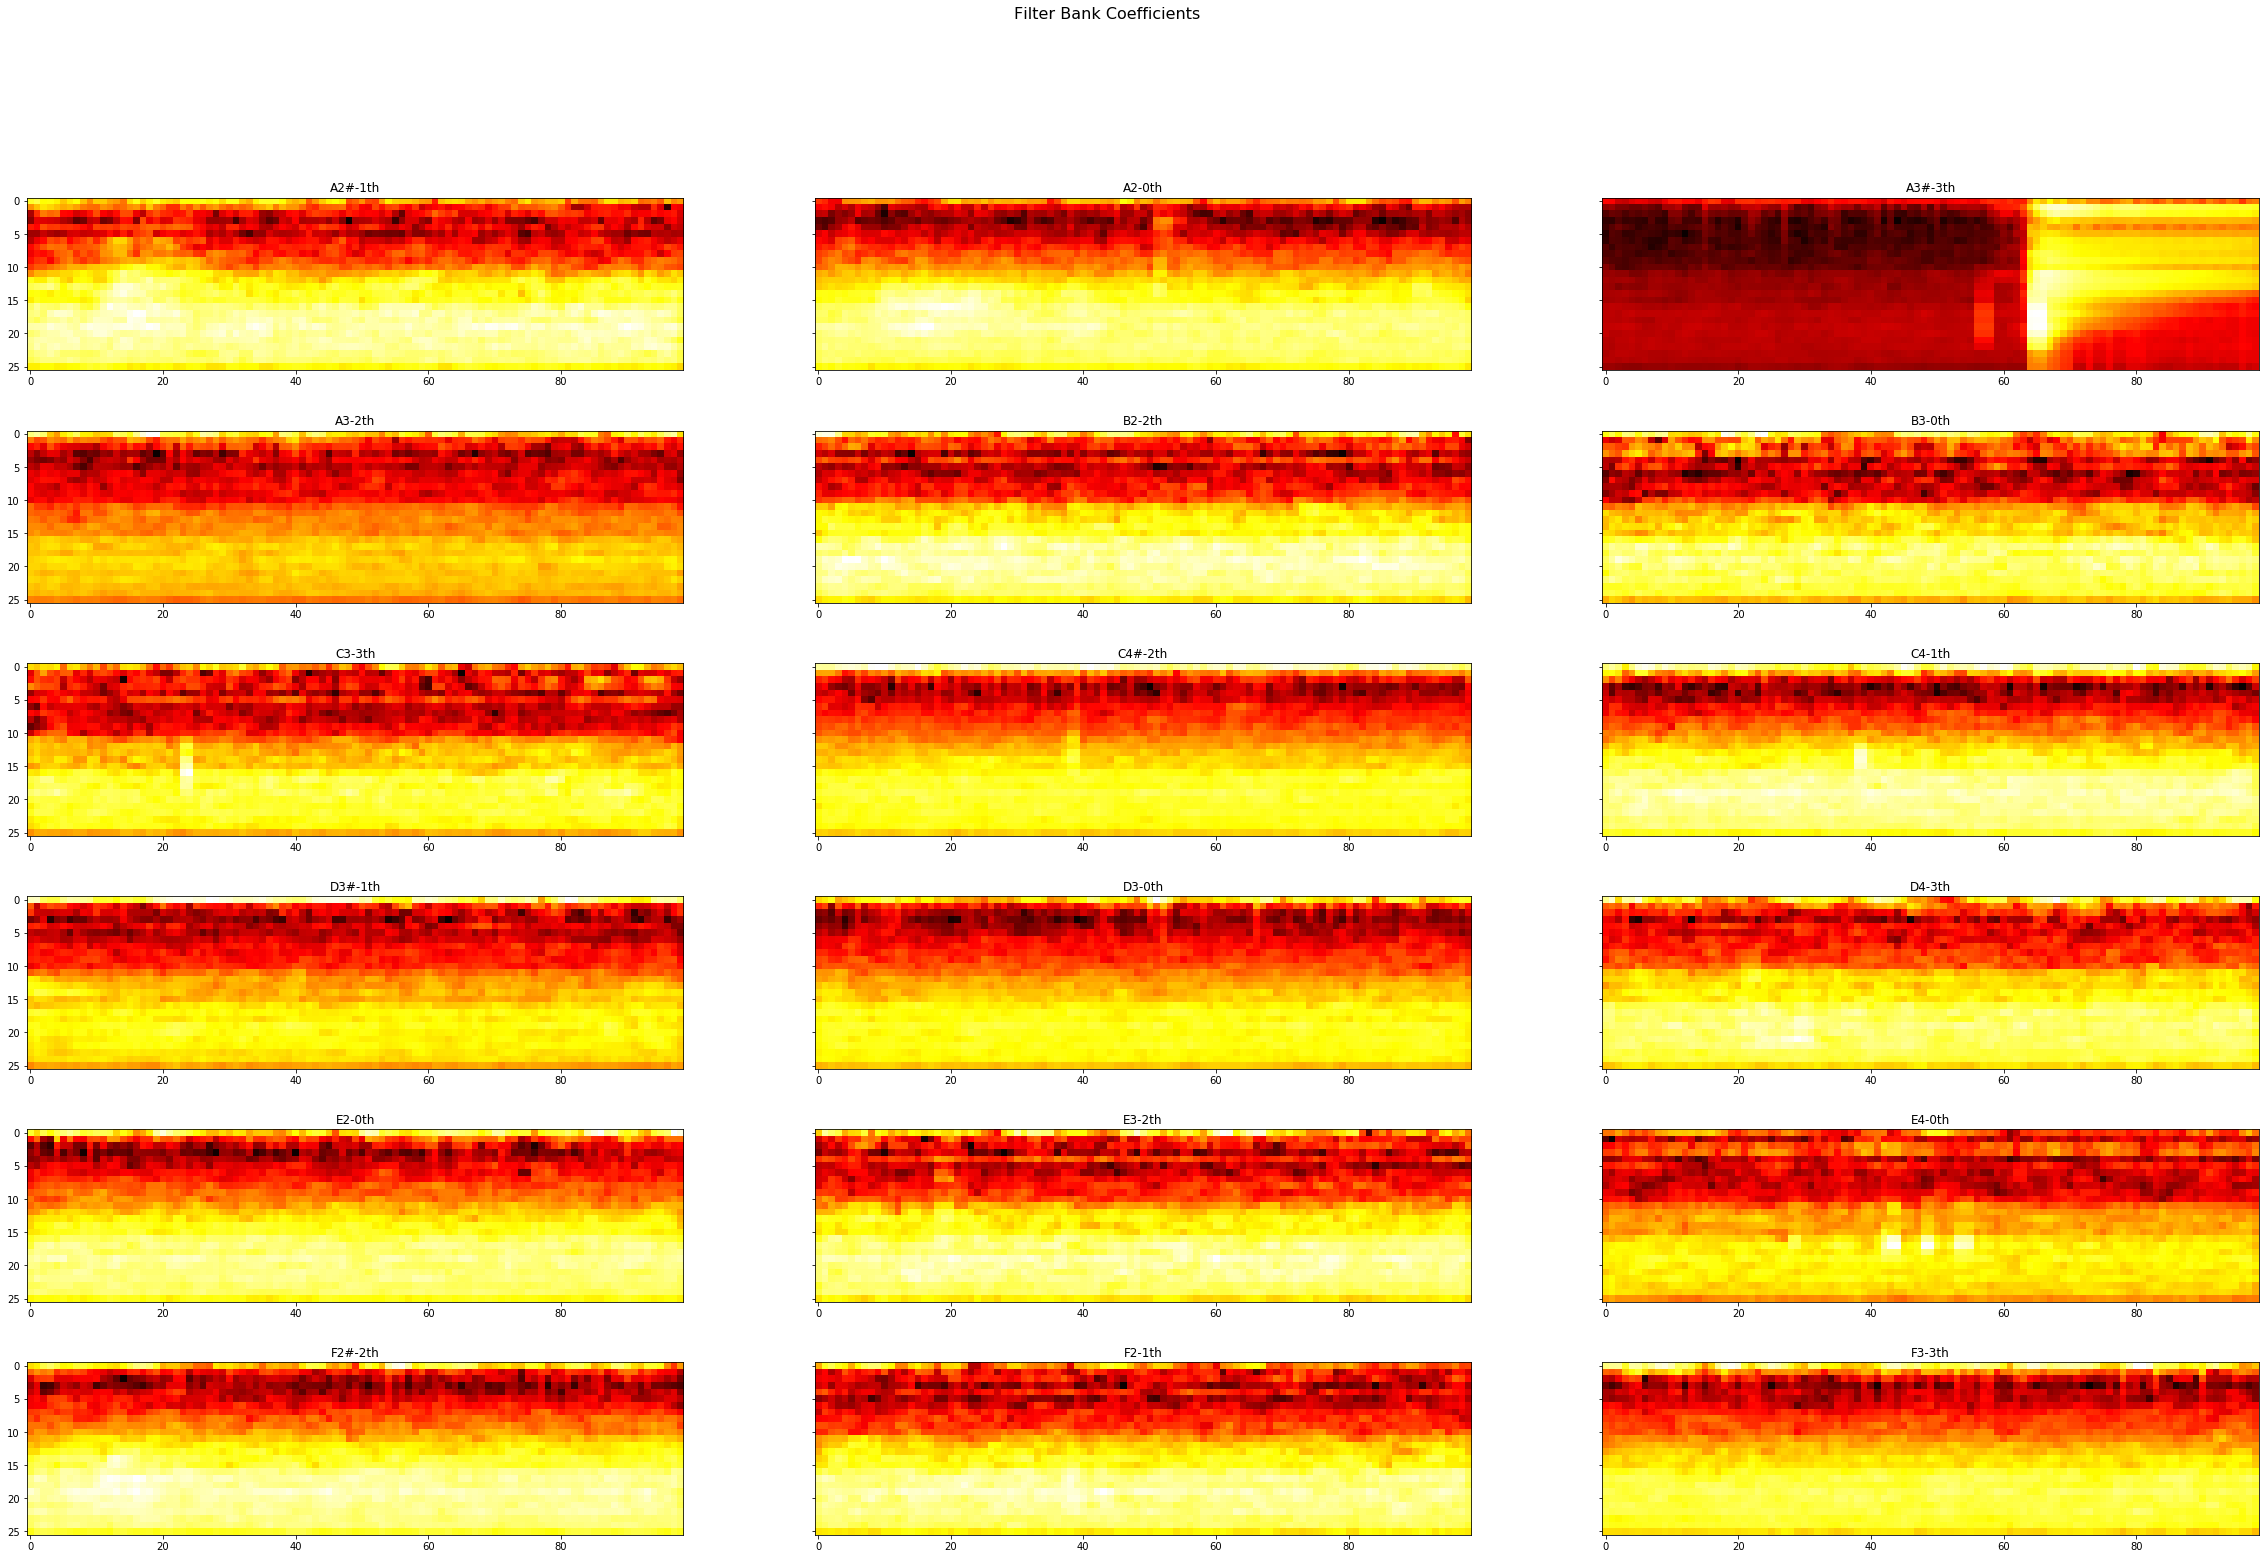

In [18]:
# Filter Bank Coeffiecients

plot_fbank(fbank)

plt.show()

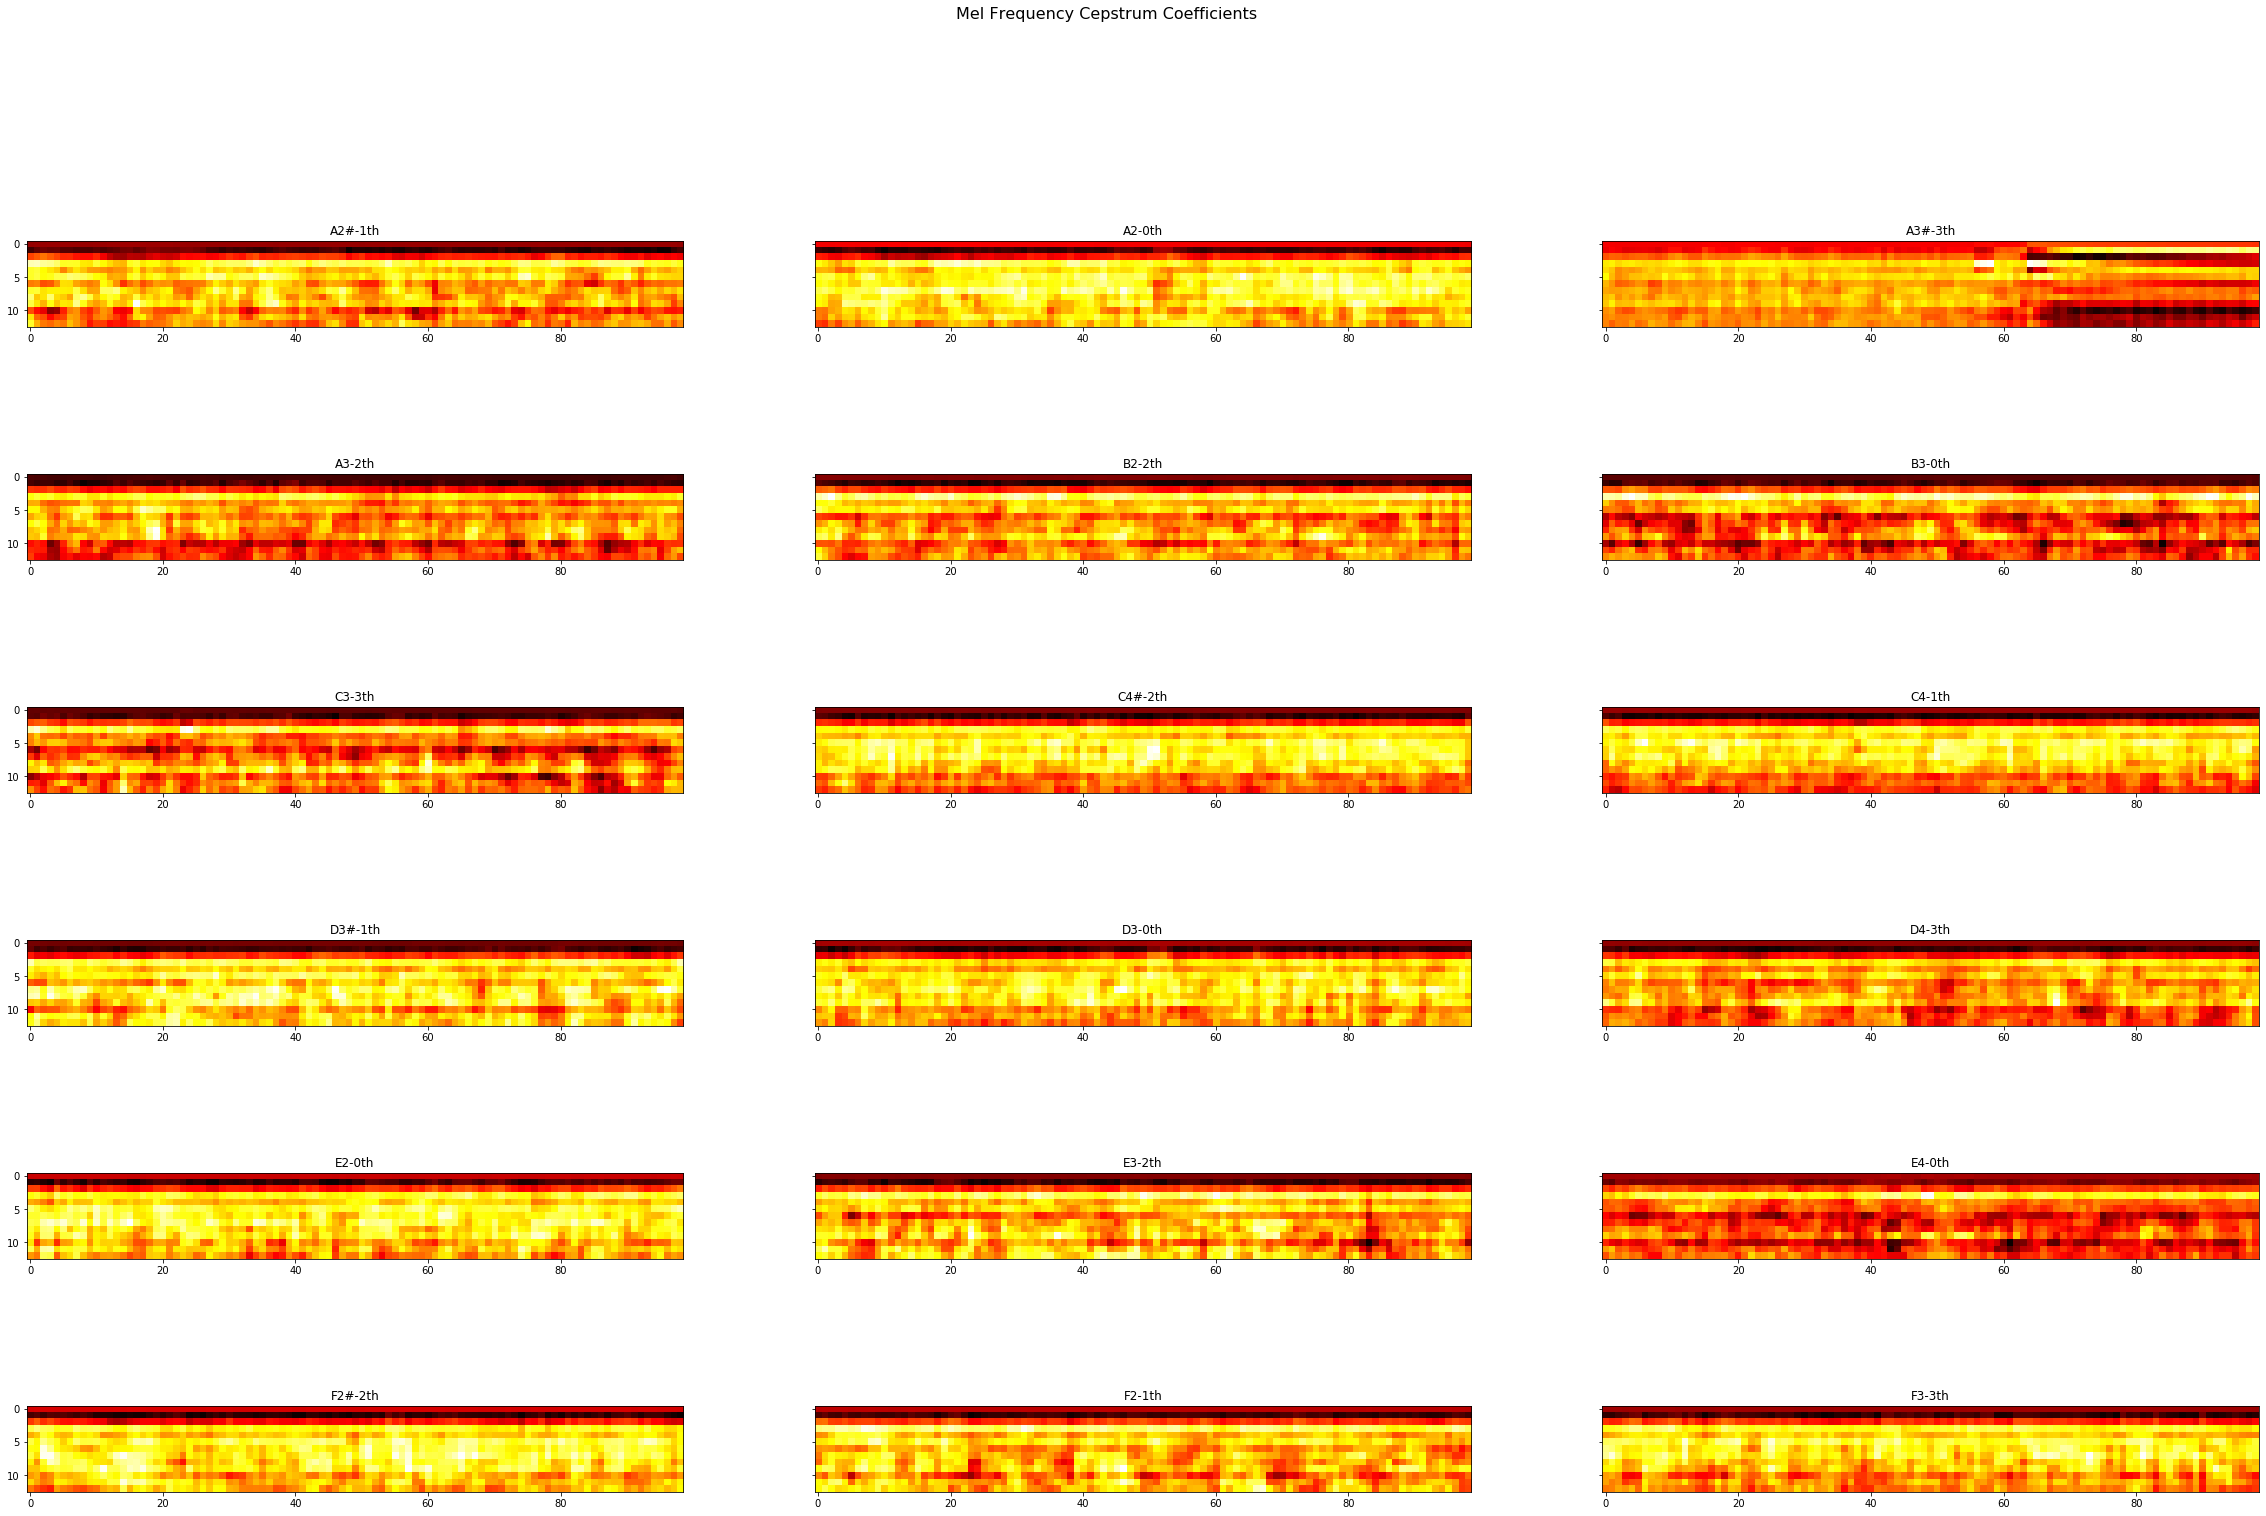

In [19]:
# # Mel Frequency Cepstrum Coefficients

plot_mfccs(mfccs)

plt.show()

In [20]:
# We need to save new sound files after cleaning "noise"

for f in tqdm(df.fname):
    
    rate, signal = wavfile.read('Data-raw/'+f)
        
    mask = envelope(signal, rate, 0.006)
        
    wavfile.write(filename='Data-clean/'+f, rate=rate, data=signal[mask])

100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [01:40<00:00,  9.04it/s]


In order to see the difference between raw file and clean file. We will use librosa to load the audio file into an array then librosa.display and matplotlib to display the waveform.

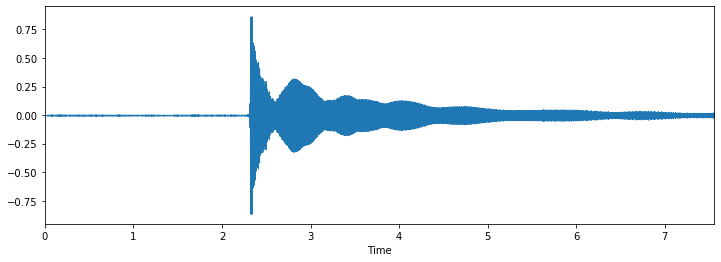

In [21]:
# Raw data

filename = './Data-raw/E2-0th-myguitar-8.wav'

plt.figure(figsize=(12,4))

data,sample_rate = librosa.load(filename)

_ = librosa.display.waveplot(data,sr=sample_rate)

ipd.Audio(filename)

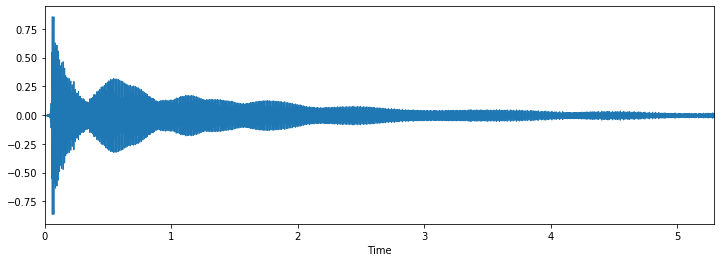

In [22]:
# Clean data

filename = './Data-clean/E2-0th-myguitar-8.wav'

plt.figure(figsize=(12,4))

data,sample_rate = librosa.load(filename)

_ = librosa.display.waveplot(data,sr=sample_rate)

ipd.Audio(filename)

## Data Preprocessing and Data Splitting

In [23]:
# Set 'frame' as index column

df.set_index('fname', inplace =True)

df.head()

label position    length
fname                                           
E2-0th-myguitar-1.wav  E2-0th    6th-0  9.226667
E2-0th-myguitar-2.wav  E2-0th    6th-0  6.128005
E2-0th-myguitar-3.wav  E2-0th    6th-0  7.050658
E2-0th-myguitar-4.wav  E2-0th    6th-0  7.226667
E2-0th-myguitar-5.wav  E2-0th    6th-0  8.458662

In [24]:
# Calculate probability distribution for each class

prob_dist = class_dist/class_dist.sum()

prob_dist

label
A2#-1th    0.041152
A2-0th     0.049856
A3#-3th    0.042574
A3-2th     0.041970
B2-2th     0.040528
B3-0th     0.040898
C3-3th     0.039853
C4#-2th    0.039076
C4-1th     0.042029
D3#-1th    0.048617
D3-0th     0.041335
D4-3th     0.042270
E2-0th     0.050115
E3-2th     0.040060
E4-0th     0.039059
F2#-2th    0.040749
F2-1th     0.037825
F3-3th     0.039214
F4#-2th    0.038283
F4-1th     0.038401
G2-3th     0.038720
G3#-1th    0.045969
G3-0th     0.042592
G4-3th     0.038856
Name: length, dtype: float64

In [25]:
# Set values based on "Short-Time Fourier Transform" with 
# sample rate = 44100
# window length = 25 ms = 400 samples
# step size = 10 ms = 160 samples
# down size rate from 32000 to 16000

nfilt = 26

nfeat = 13

nfft =  1103

rate = 16000

n_samples = 2 * int(df['length'].sum()/0.1)

n_samples

79188

In [26]:
# Assigning X and y values

X = []

y = []

for _ in tqdm(range(n_samples)):
        
    rand_class = np.random.choice(class_dist.index, p = prob_dist)
        
    file = np.random.choice(df[df.label == rand_class].index)
        
    rate, wav = wavfile.read('Data-clean/'+file)
        
    label = df.at[file, 'label']
        
    rand_index = np.random.randint(0, wav.shape[0]- int(16000/10))
        
    sample = wav[rand_index:rand_index + int(16000/10)]
        
    X_sample = mfcc(sample, rate, numcep = nfeat, nfilt = nfilt, nfft=nfft)
        
    X.append(X_sample)
        
    y.append(classes.index(label))

100%|███████████████████████████████████████████████████████████████████████████| 79188/79188 [07:55<00:00, 166.67it/s]


In [28]:
X.shape

(79188, 3, 13)

In [29]:
# Preprocessing X values

X, y = np.array(X), np.array(y)

X = X.reshape(79188, 3*13)

scaler = MinMaxScaler()

X = scaler.fit_transform(X)

X = X.reshape(79188, 3, 13)
    
X_conv = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

X_recurr = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [30]:
# Pre-processing y values

lb = LabelBinarizer()

y = lb.fit_transform(y)

y_conv = y

y_recurr = y

In [31]:
# Split the dataset into training and testing sets with a random state.

X_train_conv, X_test_conv, y_train_conv, y_test_conv = train_test_split(X_conv, y_conv, random_state = 42)

X_train_recurr, X_test_recurr, y_train_recurr, y_test_recurr = train_test_split(X_recurr, y_recurr, random_state = 42)

## Model Training and Evaluation

In [32]:
# Convolutional Neural Networks

def get_conv_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', strides = (1,1), padding='same', input_shape = input_shape_conv))
    
    model.add(Conv2D(32, (3,3), activation='relu', strides = (1,1), padding = 'same'))
    
    model.add(Conv2D(64, (3,3), activation='relu', strides = (1,1), padding = 'same'))
    
    model.add(Conv2D(128, (3,3), activation='relu', strides = (1,1), padding = 'same'))
    
    model.add(MaxPooling2D((2,2)))
    
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(len(classes), activation='softmax'))
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    
    return model

In [33]:
# Recurrent Neural Networks

def get_recurrent_model():
    
    # shape of data for RNN is (n, time, feat)
    
    model = Sequential()
    
    model.add(LSTM(128, return_sequences=True, input_shape = input_shape_recurr))
    
    model.add(LSTM(128, return_sequences=True))
    
    model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Dense(64, activation='relu')))
    
    model.add(TimeDistributed(Dense(32, activation='relu')))
    
    model.add(TimeDistributed(Dense(16, activation='relu')))
    
    model.add(TimeDistributed(Dense(8, activation='relu')))
    
    model.add(Flatten())
    
    model.add(Dense(len(classes), activation='softmax'))
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    
    return model

In [34]:
# Calculate y_flat for tuning

y_flat_conv = np.argmax(y_train_conv, axis=1)

y_flat_recurr = np.argmax(y_train_recurr, axis=1)

# Define input_shape for each model
    
input_shape_conv = (X_conv.shape[1], X.shape[2], 1)

input_shape_recurr = (X_recurr.shape[1], X.shape[2])

# Getting models    
model_conv = get_conv_model()

model_recurr = get_recurrent_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 13, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 13, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 13, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)  

In [35]:
# Calculate class weight for CNN model

class_weight_conv = compute_class_weight('balanced', np.unique(y_flat_conv), y_flat_conv)

In [36]:
# Calculate class weight for RNN model

class_weight_recurr = compute_class_weight('balanced', np.unique(y_flat_recurr), y_flat_recurr)

In [37]:
# Using ModelCheckpoint to save the best model for CNN

file_path = "Best-models/best_conv.h5"

checkpoint_conv = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, mode='max', save_best_only = True, 
                                     save_weights_only=False, period=1)

In [38]:
# Using ModelCheckpoint to save the best model for RNN

file_path = "Best-models/best_recurr.h5"

checkpoint_recurr = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, mode='max', save_best_only = True, 
                                     save_weights_only=False, period=1)

In [39]:
# Running CNN model

history_conv = model_conv.fit(X_train_conv, y_train_conv, epochs=10, batch_size=32, shuffle=True, 
                                class_weight = class_weight_conv, validation_split=0.1,
                                callbacks = [checkpoint_conv])

Instructions for updating:
Use tf.cast instead.
Train on 53451 samples, validate on 5940 samples
Epoch 1/10


16416/53451 [========>.....................] - ETA: 46:30 - loss: 3.1707 - acc: 0.06 - ETA: 15:58 - loss: 3.1800 - acc: 0.02 - ETA: 8:17 - loss: 3.1785 - acc: 0.0312 - ETA: 6:22 - loss: 3.1815 - acc: 0.039 - ETA: 4:47 - loss: 3.1787 - acc: 0.036 - ETA: 3:52 - loss: 3.1817 - acc: 0.033 - ETA: 3:17 - loss: 3.1819 - acc: 0.027 - ETA: 2:52 - loss: 3.1815 - acc: 0.031 - ETA: 2:40 - loss: 3.1809 - acc: 0.032 - ETA: 2:30 - loss: 3.1800 - acc: 0.032 - ETA: 2:22 - loss: 3.1797 - acc: 0.033 - ETA: 2:11 - loss: 3.1784 - acc: 0.036 - ETA: 2:02 - loss: 3.1776 - acc: 0.041 - ETA: 1:54 - loss: 3.1779 - acc: 0.039 - ETA: 1:48 - loss: 3.1788 - acc: 0.041 - ETA: 1:42 - loss: 3.1790 - acc: 0.041 - ETA: 1:40 - loss: 3.1787 - acc: 0.040 - ETA: 1:35 - loss: 3.1785 - acc: 0.040 - ETA: 1:31 - loss: 3.1786 - acc: 0.040 - ETA: 1:28 - loss: 3.1780 - acc: 0.040 - ETA: 1:26 - loss: 3.1778 - acc: 0.039 - ETA: 1:25 - loss: 3.1774 - acc: 0.040 - ETA: 1:22 - loss: 3.1763 - acc: 0.042 - ETA: 1:19 - loss: 3.1764 - acc: 

34560/53451 [==================>...........] - ETA: 34s - loss: 2.3085 - acc: 0.26 - ETA: 33s - loss: 2.3047 - acc: 0.26 - ETA: 33s - loss: 2.3034 - acc: 0.26 - ETA: 33s - loss: 2.3004 - acc: 0.26 - ETA: 33s - loss: 2.2959 - acc: 0.27 - ETA: 33s - loss: 2.2920 - acc: 0.27 - ETA: 33s - loss: 2.2875 - acc: 0.27 - ETA: 32s - loss: 2.2833 - acc: 0.27 - ETA: 32s - loss: 2.2790 - acc: 0.27 - ETA: 32s - loss: 2.2757 - acc: 0.27 - ETA: 32s - loss: 2.2714 - acc: 0.27 - ETA: 32s - loss: 2.2678 - acc: 0.27 - ETA: 32s - loss: 2.2637 - acc: 0.28 - ETA: 32s - loss: 2.2606 - acc: 0.28 - ETA: 31s - loss: 2.2572 - acc: 0.28 - ETA: 31s - loss: 2.2555 - acc: 0.28 - ETA: 31s - loss: 2.2533 - acc: 0.28 - ETA: 31s - loss: 2.2496 - acc: 0.28 - ETA: 31s - loss: 2.2465 - acc: 0.28 - ETA: 31s - loss: 2.2419 - acc: 0.28 - ETA: 31s - loss: 2.2391 - acc: 0.28 - ETA: 30s - loss: 2.2353 - acc: 0.28 - ETA: 30s - loss: 2.2318 - acc: 0.28 - ETA: 30s - loss: 2.2283 - acc: 0.29 - ETA: 30s - loss: 2.2246 - acc: 0.29 - ETA

52832/53451 [============================>.] - ETA: 15s - loss: 1.9021 - acc: 0.37 - ETA: 15s - loss: 1.9007 - acc: 0.37 - ETA: 15s - loss: 1.8996 - acc: 0.37 - ETA: 15s - loss: 1.8980 - acc: 0.37 - ETA: 15s - loss: 1.8970 - acc: 0.37 - ETA: 15s - loss: 1.8958 - acc: 0.38 - ETA: 14s - loss: 1.8944 - acc: 0.38 - ETA: 14s - loss: 1.8933 - acc: 0.38 - ETA: 14s - loss: 1.8924 - acc: 0.38 - ETA: 14s - loss: 1.8916 - acc: 0.38 - ETA: 14s - loss: 1.8910 - acc: 0.38 - ETA: 14s - loss: 1.8896 - acc: 0.38 - ETA: 14s - loss: 1.8882 - acc: 0.38 - ETA: 14s - loss: 1.8870 - acc: 0.38 - ETA: 14s - loss: 1.8852 - acc: 0.38 - ETA: 14s - loss: 1.8841 - acc: 0.38 - ETA: 14s - loss: 1.8826 - acc: 0.38 - ETA: 14s - loss: 1.8814 - acc: 0.38 - ETA: 14s - loss: 1.8800 - acc: 0.38 - ETA: 14s - loss: 1.8791 - acc: 0.38 - ETA: 14s - loss: 1.8778 - acc: 0.38 - ETA: 14s - loss: 1.8772 - acc: 0.38 - ETA: 13s - loss: 1.8756 - acc: 0.38 - ETA: 13s - loss: 1.8740 - acc: 0.38 - ETA: 13s - loss: 1.8731 - acc: 0.38 - ETA

53451/53451 [==============================] - ETA: 0s - loss: 1.7006 - acc: 0.436 - ETA: 0s - loss: 1.6996 - acc: 0.436 - ETA: 0s - loss: 1.6988 - acc: 0.436 - ETA: 0s - loss: 1.6979 - acc: 0.436 - ETA: 0s - loss: 1.6974 - acc: 0.437 - ETA: 0s - loss: 1.6968 - acc: 0.437 - 43s 809us/step - loss: 1.6965 - acc: 0.4373 - val_loss: 1.1147 - val_acc: 0.6162

Epoch 00001: val_acc improved from -inf to 0.61616, saving model to Best-models/best_conv.h5
Epoch 2/10


20064/53451 [==========>...................] - ETA: 31s - loss: 1.1620 - acc: 0.50 - ETA: 29s - loss: 1.1440 - acc: 0.55 - ETA: 29s - loss: 1.2120 - acc: 0.57 - ETA: 28s - loss: 1.2460 - acc: 0.53 - ETA: 29s - loss: 1.2276 - acc: 0.54 - ETA: 29s - loss: 1.2189 - acc: 0.55 - ETA: 29s - loss: 1.2147 - acc: 0.56 - ETA: 29s - loss: 1.2213 - acc: 0.56 - ETA: 29s - loss: 1.2501 - acc: 0.56 - ETA: 29s - loss: 1.2499 - acc: 0.56 - ETA: 29s - loss: 1.2691 - acc: 0.55 - ETA: 29s - loss: 1.2713 - acc: 0.56 - ETA: 29s - loss: 1.2639 - acc: 0.56 - ETA: 29s - loss: 1.2680 - acc: 0.56 - ETA: 30s - loss: 1.2555 - acc: 0.56 - ETA: 30s - loss: 1.2586 - acc: 0.56 - ETA: 30s - loss: 1.2539 - acc: 0.56 - ETA: 30s - loss: 1.2454 - acc: 0.57 - ETA: 30s - loss: 1.2361 - acc: 0.57 - ETA: 30s - loss: 1.2254 - acc: 0.58 - ETA: 30s - loss: 1.2278 - acc: 0.58 - ETA: 29s - loss: 1.2286 - acc: 0.58 - ETA: 29s - loss: 1.2265 - acc: 0.58 - ETA: 29s - loss: 1.2277 - acc: 0.58 - ETA: 29s - loss: 1.2344 - acc: 0.58 - ETA

40096/53451 [=====================>........] - ETA: 20s - loss: 1.1983 - acc: 0.58 - ETA: 20s - loss: 1.1973 - acc: 0.58 - ETA: 20s - loss: 1.1973 - acc: 0.58 - ETA: 20s - loss: 1.1971 - acc: 0.58 - ETA: 20s - loss: 1.1969 - acc: 0.58 - ETA: 20s - loss: 1.1968 - acc: 0.58 - ETA: 19s - loss: 1.1960 - acc: 0.58 - ETA: 19s - loss: 1.1951 - acc: 0.58 - ETA: 19s - loss: 1.1954 - acc: 0.58 - ETA: 19s - loss: 1.1947 - acc: 0.58 - ETA: 19s - loss: 1.1942 - acc: 0.58 - ETA: 19s - loss: 1.1941 - acc: 0.58 - ETA: 19s - loss: 1.1944 - acc: 0.58 - ETA: 19s - loss: 1.1942 - acc: 0.58 - ETA: 19s - loss: 1.1939 - acc: 0.58 - ETA: 19s - loss: 1.1935 - acc: 0.58 - ETA: 19s - loss: 1.1933 - acc: 0.58 - ETA: 19s - loss: 1.1930 - acc: 0.58 - ETA: 19s - loss: 1.1931 - acc: 0.58 - ETA: 19s - loss: 1.1937 - acc: 0.58 - ETA: 19s - loss: 1.1938 - acc: 0.58 - ETA: 19s - loss: 1.1931 - acc: 0.58 - ETA: 18s - loss: 1.1924 - acc: 0.58 - ETA: 18s - loss: 1.1919 - acc: 0.58 - ETA: 18s - loss: 1.1911 - acc: 0.58 - ETA

53451/53451 [==============================] - ETA: 8s - loss: 1.1538 - acc: 0.602 - ETA: 8s - loss: 1.1535 - acc: 0.602 - ETA: 8s - loss: 1.1531 - acc: 0.602 - ETA: 8s - loss: 1.1529 - acc: 0.602 - ETA: 8s - loss: 1.1527 - acc: 0.602 - ETA: 7s - loss: 1.1529 - acc: 0.602 - ETA: 7s - loss: 1.1526 - acc: 0.603 - ETA: 7s - loss: 1.1524 - acc: 0.603 - ETA: 7s - loss: 1.1521 - acc: 0.603 - ETA: 7s - loss: 1.1523 - acc: 0.603 - ETA: 7s - loss: 1.1523 - acc: 0.603 - ETA: 7s - loss: 1.1522 - acc: 0.603 - ETA: 7s - loss: 1.1516 - acc: 0.603 - ETA: 7s - loss: 1.1519 - acc: 0.603 - ETA: 7s - loss: 1.1515 - acc: 0.603 - ETA: 7s - loss: 1.1518 - acc: 0.603 - ETA: 7s - loss: 1.1517 - acc: 0.603 - ETA: 7s - loss: 1.1516 - acc: 0.603 - ETA: 7s - loss: 1.1510 - acc: 0.603 - ETA: 7s - loss: 1.1505 - acc: 0.603 - ETA: 7s - loss: 1.1508 - acc: 0.603 - ETA: 7s - loss: 1.1502 - acc: 0.603 - ETA: 6s - loss: 1.1495 - acc: 0.604 - ETA: 6s - loss: 1.1494 - acc: 0.603 - ETA: 6s - loss: 1.1487 - acc: 0.604 - ETA

20288/53451 [==========>...................] - ETA: 36s - loss: 0.9185 - acc: 0.71 - ETA: 32s - loss: 1.0535 - acc: 0.68 - ETA: 30s - loss: 1.0340 - acc: 0.67 - ETA: 30s - loss: 1.0143 - acc: 0.66 - ETA: 29s - loss: 1.0367 - acc: 0.66 - ETA: 29s - loss: 1.0537 - acc: 0.66 - ETA: 29s - loss: 1.0857 - acc: 0.64 - ETA: 29s - loss: 1.0857 - acc: 0.64 - ETA: 29s - loss: 1.0716 - acc: 0.64 - ETA: 29s - loss: 1.0656 - acc: 0.64 - ETA: 28s - loss: 1.0535 - acc: 0.64 - ETA: 29s - loss: 1.0344 - acc: 0.65 - ETA: 29s - loss: 1.0453 - acc: 0.64 - ETA: 29s - loss: 1.0391 - acc: 0.65 - ETA: 30s - loss: 1.0374 - acc: 0.65 - ETA: 30s - loss: 1.0317 - acc: 0.65 - ETA: 30s - loss: 1.0334 - acc: 0.65 - ETA: 31s - loss: 1.0248 - acc: 0.65 - ETA: 31s - loss: 1.0235 - acc: 0.65 - ETA: 31s - loss: 1.0231 - acc: 0.65 - ETA: 31s - loss: 1.0217 - acc: 0.65 - ETA: 31s - loss: 1.0262 - acc: 0.64 - ETA: 31s - loss: 1.0172 - acc: 0.65 - ETA: 31s - loss: 1.0058 - acc: 0.65 - ETA: 31s - loss: 1.0080 - acc: 0.65 - ETA

40800/53451 [=====================>........] - ETA: 19s - loss: 0.9998 - acc: 0.65 - ETA: 19s - loss: 0.9999 - acc: 0.65 - ETA: 19s - loss: 1.0008 - acc: 0.65 - ETA: 19s - loss: 1.0005 - acc: 0.65 - ETA: 19s - loss: 1.0014 - acc: 0.65 - ETA: 19s - loss: 1.0016 - acc: 0.65 - ETA: 19s - loss: 1.0014 - acc: 0.65 - ETA: 19s - loss: 1.0016 - acc: 0.65 - ETA: 18s - loss: 1.0025 - acc: 0.65 - ETA: 18s - loss: 1.0023 - acc: 0.65 - ETA: 18s - loss: 1.0023 - acc: 0.65 - ETA: 18s - loss: 1.0011 - acc: 0.65 - ETA: 18s - loss: 1.0026 - acc: 0.65 - ETA: 18s - loss: 1.0021 - acc: 0.65 - ETA: 18s - loss: 1.0018 - acc: 0.65 - ETA: 18s - loss: 1.0017 - acc: 0.65 - ETA: 18s - loss: 1.0013 - acc: 0.65 - ETA: 18s - loss: 1.0006 - acc: 0.65 - ETA: 18s - loss: 0.9997 - acc: 0.65 - ETA: 18s - loss: 1.0000 - acc: 0.65 - ETA: 18s - loss: 0.9991 - acc: 0.65 - ETA: 18s - loss: 0.9987 - acc: 0.65 - ETA: 18s - loss: 0.9978 - acc: 0.65 - ETA: 18s - loss: 0.9975 - acc: 0.65 - ETA: 18s - loss: 0.9974 - acc: 0.65 - ETA

53451/53451 [==============================] - ETA: 7s - loss: 0.9829 - acc: 0.664 - ETA: 7s - loss: 0.9831 - acc: 0.663 - ETA: 7s - loss: 0.9830 - acc: 0.663 - ETA: 7s - loss: 0.9827 - acc: 0.664 - ETA: 7s - loss: 0.9829 - acc: 0.664 - ETA: 7s - loss: 0.9826 - acc: 0.664 - ETA: 7s - loss: 0.9824 - acc: 0.664 - ETA: 7s - loss: 0.9830 - acc: 0.664 - ETA: 7s - loss: 0.9833 - acc: 0.664 - ETA: 7s - loss: 0.9832 - acc: 0.664 - ETA: 6s - loss: 0.9829 - acc: 0.664 - ETA: 6s - loss: 0.9826 - acc: 0.664 - ETA: 6s - loss: 0.9822 - acc: 0.664 - ETA: 6s - loss: 0.9821 - acc: 0.664 - ETA: 6s - loss: 0.9817 - acc: 0.664 - ETA: 6s - loss: 0.9818 - acc: 0.664 - ETA: 6s - loss: 0.9816 - acc: 0.664 - ETA: 6s - loss: 0.9816 - acc: 0.664 - ETA: 6s - loss: 0.9819 - acc: 0.664 - ETA: 6s - loss: 0.9818 - acc: 0.664 - ETA: 6s - loss: 0.9816 - acc: 0.664 - ETA: 6s - loss: 0.9814 - acc: 0.664 - ETA: 6s - loss: 0.9813 - acc: 0.664 - ETA: 6s - loss: 0.9815 - acc: 0.664 - ETA: 6s - loss: 0.9808 - acc: 0.664 - ETA

19392/53451 [=========>....................] - ETA: 42s - loss: 1.1441 - acc: 0.71 - ETA: 33s - loss: 0.9279 - acc: 0.68 - ETA: 31s - loss: 0.9858 - acc: 0.66 - ETA: 31s - loss: 0.9510 - acc: 0.68 - ETA: 32s - loss: 0.9717 - acc: 0.68 - ETA: 32s - loss: 0.9801 - acc: 0.67 - ETA: 31s - loss: 0.9550 - acc: 0.67 - ETA: 31s - loss: 0.9265 - acc: 0.68 - ETA: 31s - loss: 0.9156 - acc: 0.68 - ETA: 32s - loss: 0.9200 - acc: 0.68 - ETA: 31s - loss: 0.9165 - acc: 0.68 - ETA: 31s - loss: 0.9219 - acc: 0.68 - ETA: 31s - loss: 0.9240 - acc: 0.68 - ETA: 31s - loss: 0.9172 - acc: 0.69 - ETA: 30s - loss: 0.9248 - acc: 0.68 - ETA: 30s - loss: 0.9279 - acc: 0.68 - ETA: 30s - loss: 0.9266 - acc: 0.68 - ETA: 30s - loss: 0.9290 - acc: 0.68 - ETA: 30s - loss: 0.9260 - acc: 0.68 - ETA: 29s - loss: 0.9288 - acc: 0.68 - ETA: 29s - loss: 0.9267 - acc: 0.68 - ETA: 29s - loss: 0.9259 - acc: 0.68 - ETA: 29s - loss: 0.9247 - acc: 0.68 - ETA: 29s - loss: 0.9247 - acc: 0.68 - ETA: 29s - loss: 0.9335 - acc: 0.68 - ETA

38304/53451 [====================>.........] - ETA: 22s - loss: 0.8949 - acc: 0.69 - ETA: 22s - loss: 0.8945 - acc: 0.69 - ETA: 21s - loss: 0.8958 - acc: 0.69 - ETA: 21s - loss: 0.8966 - acc: 0.69 - ETA: 21s - loss: 0.8965 - acc: 0.69 - ETA: 21s - loss: 0.8967 - acc: 0.69 - ETA: 21s - loss: 0.8956 - acc: 0.69 - ETA: 21s - loss: 0.8957 - acc: 0.69 - ETA: 21s - loss: 0.8951 - acc: 0.69 - ETA: 21s - loss: 0.8951 - acc: 0.69 - ETA: 21s - loss: 0.8954 - acc: 0.69 - ETA: 21s - loss: 0.8954 - acc: 0.69 - ETA: 21s - loss: 0.8960 - acc: 0.69 - ETA: 21s - loss: 0.8946 - acc: 0.69 - ETA: 21s - loss: 0.8950 - acc: 0.69 - ETA: 21s - loss: 0.8953 - acc: 0.69 - ETA: 21s - loss: 0.8955 - acc: 0.69 - ETA: 21s - loss: 0.8954 - acc: 0.69 - ETA: 20s - loss: 0.8948 - acc: 0.69 - ETA: 20s - loss: 0.8949 - acc: 0.69 - ETA: 20s - loss: 0.8948 - acc: 0.69 - ETA: 20s - loss: 0.8947 - acc: 0.69 - ETA: 20s - loss: 0.8956 - acc: 0.69 - ETA: 20s - loss: 0.8951 - acc: 0.69 - ETA: 20s - loss: 0.8948 - acc: 0.69 - ETA

53451/53451 [==============================] - ETA: 10s - loss: 0.8833 - acc: 0.70 - ETA: 10s - loss: 0.8829 - acc: 0.70 - ETA: 9s - loss: 0.8825 - acc: 0.7006 - ETA: 9s - loss: 0.8819 - acc: 0.700 - ETA: 9s - loss: 0.8821 - acc: 0.700 - ETA: 9s - loss: 0.8822 - acc: 0.700 - ETA: 9s - loss: 0.8825 - acc: 0.700 - ETA: 9s - loss: 0.8825 - acc: 0.700 - ETA: 9s - loss: 0.8824 - acc: 0.700 - ETA: 9s - loss: 0.8825 - acc: 0.700 - ETA: 9s - loss: 0.8826 - acc: 0.700 - ETA: 9s - loss: 0.8824 - acc: 0.700 - ETA: 9s - loss: 0.8828 - acc: 0.700 - ETA: 9s - loss: 0.8824 - acc: 0.700 - ETA: 9s - loss: 0.8823 - acc: 0.700 - ETA: 9s - loss: 0.8819 - acc: 0.700 - ETA: 9s - loss: 0.8822 - acc: 0.700 - ETA: 9s - loss: 0.8820 - acc: 0.700 - ETA: 9s - loss: 0.8830 - acc: 0.700 - ETA: 9s - loss: 0.8832 - acc: 0.700 - ETA: 9s - loss: 0.8831 - acc: 0.700 - ETA: 9s - loss: 0.8831 - acc: 0.700 - ETA: 9s - loss: 0.8832 - acc: 0.700 - ETA: 9s - loss: 0.8833 - acc: 0.700 - ETA: 9s - loss: 0.8831 - acc: 0.700 - ET

20480/53451 [==========>...................] - ETA: 34s - loss: 0.3571 - acc: 0.93 - ETA: 33s - loss: 0.6921 - acc: 0.80 - ETA: 35s - loss: 0.7933 - acc: 0.74 - ETA: 35s - loss: 0.8268 - acc: 0.73 - ETA: 34s - loss: 0.8425 - acc: 0.73 - ETA: 34s - loss: 0.8072 - acc: 0.74 - ETA: 35s - loss: 0.8305 - acc: 0.73 - ETA: 34s - loss: 0.8386 - acc: 0.73 - ETA: 35s - loss: 0.8269 - acc: 0.73 - ETA: 34s - loss: 0.8144 - acc: 0.73 - ETA: 35s - loss: 0.8259 - acc: 0.73 - ETA: 35s - loss: 0.8292 - acc: 0.73 - ETA: 35s - loss: 0.8339 - acc: 0.72 - ETA: 34s - loss: 0.8375 - acc: 0.72 - ETA: 34s - loss: 0.8355 - acc: 0.72 - ETA: 34s - loss: 0.8357 - acc: 0.72 - ETA: 34s - loss: 0.8403 - acc: 0.72 - ETA: 33s - loss: 0.8482 - acc: 0.72 - ETA: 33s - loss: 0.8445 - acc: 0.72 - ETA: 33s - loss: 0.8440 - acc: 0.72 - ETA: 33s - loss: 0.8359 - acc: 0.72 - ETA: 32s - loss: 0.8341 - acc: 0.72 - ETA: 32s - loss: 0.8297 - acc: 0.73 - ETA: 32s - loss: 0.8244 - acc: 0.73 - ETA: 32s - loss: 0.8205 - acc: 0.73 - ETA

40192/53451 [=====================>........] - ETA: 19s - loss: 0.8297 - acc: 0.71 - ETA: 19s - loss: 0.8301 - acc: 0.71 - ETA: 19s - loss: 0.8304 - acc: 0.71 - ETA: 19s - loss: 0.8296 - acc: 0.71 - ETA: 19s - loss: 0.8300 - acc: 0.71 - ETA: 19s - loss: 0.8290 - acc: 0.71 - ETA: 19s - loss: 0.8286 - acc: 0.71 - ETA: 19s - loss: 0.8285 - acc: 0.71 - ETA: 19s - loss: 0.8276 - acc: 0.71 - ETA: 18s - loss: 0.8272 - acc: 0.71 - ETA: 18s - loss: 0.8270 - acc: 0.71 - ETA: 18s - loss: 0.8266 - acc: 0.71 - ETA: 18s - loss: 0.8260 - acc: 0.71 - ETA: 18s - loss: 0.8252 - acc: 0.72 - ETA: 18s - loss: 0.8257 - acc: 0.72 - ETA: 18s - loss: 0.8262 - acc: 0.71 - ETA: 18s - loss: 0.8268 - acc: 0.71 - ETA: 18s - loss: 0.8273 - acc: 0.71 - ETA: 18s - loss: 0.8280 - acc: 0.71 - ETA: 18s - loss: 0.8281 - acc: 0.71 - ETA: 18s - loss: 0.8279 - acc: 0.71 - ETA: 18s - loss: 0.8281 - acc: 0.71 - ETA: 18s - loss: 0.8284 - acc: 0.71 - ETA: 18s - loss: 0.8288 - acc: 0.71 - ETA: 18s - loss: 0.8282 - acc: 0.71 - ETA

53451/53451 [==============================] - ETA: 7s - loss: 0.8262 - acc: 0.720 - ETA: 7s - loss: 0.8262 - acc: 0.720 - ETA: 7s - loss: 0.8257 - acc: 0.720 - ETA: 7s - loss: 0.8255 - acc: 0.720 - ETA: 7s - loss: 0.8255 - acc: 0.720 - ETA: 7s - loss: 0.8254 - acc: 0.720 - ETA: 7s - loss: 0.8254 - acc: 0.720 - ETA: 7s - loss: 0.8251 - acc: 0.720 - ETA: 7s - loss: 0.8252 - acc: 0.720 - ETA: 7s - loss: 0.8249 - acc: 0.720 - ETA: 7s - loss: 0.8248 - acc: 0.720 - ETA: 7s - loss: 0.8249 - acc: 0.720 - ETA: 7s - loss: 0.8252 - acc: 0.720 - ETA: 7s - loss: 0.8253 - acc: 0.720 - ETA: 7s - loss: 0.8250 - acc: 0.720 - ETA: 7s - loss: 0.8250 - acc: 0.720 - ETA: 7s - loss: 0.8253 - acc: 0.720 - ETA: 6s - loss: 0.8252 - acc: 0.720 - ETA: 6s - loss: 0.8250 - acc: 0.720 - ETA: 6s - loss: 0.8252 - acc: 0.720 - ETA: 6s - loss: 0.8250 - acc: 0.720 - ETA: 6s - loss: 0.8250 - acc: 0.720 - ETA: 6s - loss: 0.8247 - acc: 0.720 - ETA: 6s - loss: 0.8242 - acc: 0.720 - ETA: 6s - loss: 0.8243 - acc: 0.720 - ETA

19968/53451 [==========>...................] - ETA: 35s - loss: 0.9246 - acc: 0.68 - ETA: 35s - loss: 0.7444 - acc: 0.72 - ETA: 35s - loss: 0.7371 - acc: 0.73 - ETA: 34s - loss: 0.7485 - acc: 0.72 - ETA: 33s - loss: 0.7712 - acc: 0.71 - ETA: 32s - loss: 0.7619 - acc: 0.73 - ETA: 32s - loss: 0.7533 - acc: 0.73 - ETA: 31s - loss: 0.7510 - acc: 0.73 - ETA: 31s - loss: 0.7552 - acc: 0.73 - ETA: 31s - loss: 0.7544 - acc: 0.73 - ETA: 31s - loss: 0.7575 - acc: 0.73 - ETA: 31s - loss: 0.7606 - acc: 0.73 - ETA: 31s - loss: 0.7627 - acc: 0.73 - ETA: 31s - loss: 0.7728 - acc: 0.73 - ETA: 31s - loss: 0.7775 - acc: 0.73 - ETA: 31s - loss: 0.7797 - acc: 0.73 - ETA: 31s - loss: 0.7801 - acc: 0.72 - ETA: 31s - loss: 0.7793 - acc: 0.72 - ETA: 31s - loss: 0.7841 - acc: 0.72 - ETA: 32s - loss: 0.7909 - acc: 0.72 - ETA: 32s - loss: 0.7935 - acc: 0.72 - ETA: 32s - loss: 0.7848 - acc: 0.72 - ETA: 32s - loss: 0.7889 - acc: 0.72 - ETA: 32s - loss: 0.7882 - acc: 0.72 - ETA: 32s - loss: 0.7853 - acc: 0.72 - ETA

39776/53451 [=====================>........] - ETA: 21s - loss: 0.7698 - acc: 0.73 - ETA: 20s - loss: 0.7701 - acc: 0.73 - ETA: 20s - loss: 0.7703 - acc: 0.73 - ETA: 20s - loss: 0.7712 - acc: 0.73 - ETA: 20s - loss: 0.7714 - acc: 0.73 - ETA: 20s - loss: 0.7712 - acc: 0.73 - ETA: 20s - loss: 0.7717 - acc: 0.73 - ETA: 20s - loss: 0.7718 - acc: 0.73 - ETA: 20s - loss: 0.7718 - acc: 0.73 - ETA: 20s - loss: 0.7714 - acc: 0.73 - ETA: 20s - loss: 0.7715 - acc: 0.73 - ETA: 20s - loss: 0.7717 - acc: 0.73 - ETA: 20s - loss: 0.7712 - acc: 0.73 - ETA: 20s - loss: 0.7707 - acc: 0.73 - ETA: 20s - loss: 0.7704 - acc: 0.73 - ETA: 20s - loss: 0.7709 - acc: 0.73 - ETA: 20s - loss: 0.7716 - acc: 0.73 - ETA: 20s - loss: 0.7721 - acc: 0.73 - ETA: 19s - loss: 0.7721 - acc: 0.73 - ETA: 19s - loss: 0.7722 - acc: 0.73 - ETA: 19s - loss: 0.7719 - acc: 0.73 - ETA: 19s - loss: 0.7719 - acc: 0.73 - ETA: 19s - loss: 0.7722 - acc: 0.73 - ETA: 19s - loss: 0.7725 - acc: 0.73 - ETA: 19s - loss: 0.7722 - acc: 0.73 - ETA

53451/53451 [==============================] - ETA: 8s - loss: 0.7678 - acc: 0.735 - ETA: 8s - loss: 0.7681 - acc: 0.735 - ETA: 8s - loss: 0.7683 - acc: 0.735 - ETA: 8s - loss: 0.7682 - acc: 0.735 - ETA: 8s - loss: 0.7684 - acc: 0.735 - ETA: 8s - loss: 0.7692 - acc: 0.735 - ETA: 8s - loss: 0.7689 - acc: 0.735 - ETA: 8s - loss: 0.7688 - acc: 0.735 - ETA: 8s - loss: 0.7689 - acc: 0.735 - ETA: 8s - loss: 0.7691 - acc: 0.735 - ETA: 8s - loss: 0.7690 - acc: 0.735 - ETA: 7s - loss: 0.7688 - acc: 0.735 - ETA: 7s - loss: 0.7690 - acc: 0.735 - ETA: 7s - loss: 0.7691 - acc: 0.735 - ETA: 7s - loss: 0.7692 - acc: 0.735 - ETA: 7s - loss: 0.7692 - acc: 0.735 - ETA: 7s - loss: 0.7694 - acc: 0.735 - ETA: 7s - loss: 0.7696 - acc: 0.735 - ETA: 7s - loss: 0.7695 - acc: 0.735 - ETA: 7s - loss: 0.7692 - acc: 0.735 - ETA: 7s - loss: 0.7695 - acc: 0.735 - ETA: 7s - loss: 0.7697 - acc: 0.735 - ETA: 7s - loss: 0.7695 - acc: 0.735 - ETA: 7s - loss: 0.7695 - acc: 0.735 - ETA: 7s - loss: 0.7696 - acc: 0.735 - ETA

19456/53451 [=========>....................] - ETA: 33s - loss: 0.9072 - acc: 0.68 - ETA: 30s - loss: 0.6169 - acc: 0.77 - ETA: 29s - loss: 0.6409 - acc: 0.75 - ETA: 29s - loss: 0.6513 - acc: 0.76 - ETA: 29s - loss: 0.6710 - acc: 0.76 - ETA: 29s - loss: 0.6608 - acc: 0.76 - ETA: 30s - loss: 0.6422 - acc: 0.77 - ETA: 30s - loss: 0.6384 - acc: 0.77 - ETA: 30s - loss: 0.6412 - acc: 0.76 - ETA: 30s - loss: 0.6484 - acc: 0.76 - ETA: 30s - loss: 0.6485 - acc: 0.76 - ETA: 30s - loss: 0.6498 - acc: 0.76 - ETA: 30s - loss: 0.6500 - acc: 0.75 - ETA: 30s - loss: 0.6532 - acc: 0.75 - ETA: 30s - loss: 0.6552 - acc: 0.76 - ETA: 30s - loss: 0.6513 - acc: 0.76 - ETA: 30s - loss: 0.6586 - acc: 0.76 - ETA: 30s - loss: 0.6484 - acc: 0.76 - ETA: 30s - loss: 0.6521 - acc: 0.76 - ETA: 30s - loss: 0.6462 - acc: 0.77 - ETA: 30s - loss: 0.6611 - acc: 0.76 - ETA: 30s - loss: 0.6601 - acc: 0.76 - ETA: 30s - loss: 0.6626 - acc: 0.76 - ETA: 30s - loss: 0.6765 - acc: 0.76 - ETA: 29s - loss: 0.6802 - acc: 0.76 - ETA

40000/53451 [=====================>........] - ETA: 21s - loss: 0.7228 - acc: 0.75 - ETA: 21s - loss: 0.7236 - acc: 0.75 - ETA: 21s - loss: 0.7234 - acc: 0.75 - ETA: 21s - loss: 0.7237 - acc: 0.75 - ETA: 21s - loss: 0.7233 - acc: 0.75 - ETA: 21s - loss: 0.7236 - acc: 0.75 - ETA: 21s - loss: 0.7235 - acc: 0.75 - ETA: 21s - loss: 0.7230 - acc: 0.75 - ETA: 21s - loss: 0.7219 - acc: 0.75 - ETA: 21s - loss: 0.7218 - acc: 0.75 - ETA: 21s - loss: 0.7221 - acc: 0.75 - ETA: 21s - loss: 0.7221 - acc: 0.75 - ETA: 21s - loss: 0.7224 - acc: 0.75 - ETA: 20s - loss: 0.7230 - acc: 0.75 - ETA: 20s - loss: 0.7227 - acc: 0.75 - ETA: 20s - loss: 0.7226 - acc: 0.75 - ETA: 20s - loss: 0.7233 - acc: 0.75 - ETA: 20s - loss: 0.7232 - acc: 0.75 - ETA: 20s - loss: 0.7228 - acc: 0.75 - ETA: 20s - loss: 0.7222 - acc: 0.75 - ETA: 20s - loss: 0.7227 - acc: 0.75 - ETA: 20s - loss: 0.7229 - acc: 0.75 - ETA: 20s - loss: 0.7235 - acc: 0.75 - ETA: 20s - loss: 0.7229 - acc: 0.75 - ETA: 20s - loss: 0.7223 - acc: 0.75 - ETA

53451/53451 [==============================] - ETA: 8s - loss: 0.7241 - acc: 0.753 - ETA: 8s - loss: 0.7240 - acc: 0.753 - ETA: 8s - loss: 0.7239 - acc: 0.753 - ETA: 8s - loss: 0.7241 - acc: 0.753 - ETA: 8s - loss: 0.7239 - acc: 0.753 - ETA: 7s - loss: 0.7240 - acc: 0.753 - ETA: 7s - loss: 0.7239 - acc: 0.753 - ETA: 7s - loss: 0.7235 - acc: 0.753 - ETA: 7s - loss: 0.7237 - acc: 0.753 - ETA: 7s - loss: 0.7241 - acc: 0.753 - ETA: 7s - loss: 0.7241 - acc: 0.753 - ETA: 7s - loss: 0.7238 - acc: 0.753 - ETA: 7s - loss: 0.7238 - acc: 0.753 - ETA: 7s - loss: 0.7241 - acc: 0.753 - ETA: 7s - loss: 0.7239 - acc: 0.753 - ETA: 7s - loss: 0.7237 - acc: 0.753 - ETA: 7s - loss: 0.7235 - acc: 0.753 - ETA: 7s - loss: 0.7233 - acc: 0.753 - ETA: 7s - loss: 0.7233 - acc: 0.753 - ETA: 7s - loss: 0.7234 - acc: 0.753 - ETA: 7s - loss: 0.7234 - acc: 0.753 - ETA: 7s - loss: 0.7232 - acc: 0.753 - ETA: 6s - loss: 0.7232 - acc: 0.753 - ETA: 6s - loss: 0.7234 - acc: 0.753 - ETA: 6s - loss: 0.7237 - acc: 0.753 - ETA

18464/53451 [=========>....................] - ETA: 42s - loss: 0.4090 - acc: 0.84 - ETA: 42s - loss: 0.7777 - acc: 0.72 - ETA: 53s - loss: 0.7481 - acc: 0.75 - ETA: 50s - loss: 0.7193 - acc: 0.77 - ETA: 45s - loss: 0.7532 - acc: 0.76 - ETA: 42s - loss: 0.7374 - acc: 0.77 - ETA: 42s - loss: 0.7743 - acc: 0.75 - ETA: 41s - loss: 0.7435 - acc: 0.76 - ETA: 39s - loss: 0.7443 - acc: 0.75 - ETA: 39s - loss: 0.7555 - acc: 0.75 - ETA: 39s - loss: 0.7443 - acc: 0.75 - ETA: 39s - loss: 0.7468 - acc: 0.75 - ETA: 39s - loss: 0.7370 - acc: 0.75 - ETA: 38s - loss: 0.7327 - acc: 0.75 - ETA: 38s - loss: 0.7274 - acc: 0.75 - ETA: 38s - loss: 0.7273 - acc: 0.76 - ETA: 38s - loss: 0.7200 - acc: 0.76 - ETA: 38s - loss: 0.7256 - acc: 0.76 - ETA: 38s - loss: 0.7365 - acc: 0.76 - ETA: 38s - loss: 0.7336 - acc: 0.76 - ETA: 38s - loss: 0.7341 - acc: 0.76 - ETA: 38s - loss: 0.7264 - acc: 0.76 - ETA: 38s - loss: 0.7273 - acc: 0.76 - ETA: 38s - loss: 0.7238 - acc: 0.76 - ETA: 37s - loss: 0.7182 - acc: 0.76 - ETA

37344/53451 [===================>..........] - ETA: 24s - loss: 0.7012 - acc: 0.76 - ETA: 24s - loss: 0.7012 - acc: 0.76 - ETA: 24s - loss: 0.7015 - acc: 0.76 - ETA: 24s - loss: 0.7010 - acc: 0.76 - ETA: 24s - loss: 0.7017 - acc: 0.76 - ETA: 24s - loss: 0.7017 - acc: 0.76 - ETA: 24s - loss: 0.7022 - acc: 0.76 - ETA: 24s - loss: 0.7020 - acc: 0.76 - ETA: 24s - loss: 0.7023 - acc: 0.76 - ETA: 24s - loss: 0.7023 - acc: 0.76 - ETA: 24s - loss: 0.7019 - acc: 0.76 - ETA: 24s - loss: 0.7016 - acc: 0.76 - ETA: 24s - loss: 0.7019 - acc: 0.76 - ETA: 23s - loss: 0.7022 - acc: 0.76 - ETA: 23s - loss: 0.7020 - acc: 0.76 - ETA: 23s - loss: 0.7028 - acc: 0.76 - ETA: 23s - loss: 0.7026 - acc: 0.76 - ETA: 23s - loss: 0.7024 - acc: 0.76 - ETA: 23s - loss: 0.7027 - acc: 0.75 - ETA: 23s - loss: 0.7028 - acc: 0.75 - ETA: 23s - loss: 0.7029 - acc: 0.75 - ETA: 23s - loss: 0.7025 - acc: 0.75 - ETA: 23s - loss: 0.7027 - acc: 0.75 - ETA: 23s - loss: 0.7018 - acc: 0.76 - ETA: 22s - loss: 0.7023 - acc: 0.75 - ETA

53451/53451 [==============================] - ETA: 11s - loss: 0.6979 - acc: 0.76 - ETA: 11s - loss: 0.6976 - acc: 0.76 - ETA: 10s - loss: 0.6973 - acc: 0.76 - ETA: 10s - loss: 0.6975 - acc: 0.76 - ETA: 10s - loss: 0.6974 - acc: 0.76 - ETA: 10s - loss: 0.6974 - acc: 0.76 - ETA: 10s - loss: 0.6976 - acc: 0.76 - ETA: 10s - loss: 0.6975 - acc: 0.76 - ETA: 10s - loss: 0.6974 - acc: 0.76 - ETA: 10s - loss: 0.6975 - acc: 0.76 - ETA: 10s - loss: 0.6972 - acc: 0.76 - ETA: 10s - loss: 0.6974 - acc: 0.76 - ETA: 10s - loss: 0.6978 - acc: 0.76 - ETA: 10s - loss: 0.6976 - acc: 0.76 - ETA: 10s - loss: 0.6974 - acc: 0.76 - ETA: 10s - loss: 0.6974 - acc: 0.76 - ETA: 10s - loss: 0.6975 - acc: 0.76 - ETA: 10s - loss: 0.6973 - acc: 0.76 - ETA: 10s - loss: 0.6971 - acc: 0.76 - ETA: 10s - loss: 0.6975 - acc: 0.76 - ETA: 10s - loss: 0.6972 - acc: 0.76 - ETA: 10s - loss: 0.6970 - acc: 0.76 - ETA: 10s - loss: 0.6971 - acc: 0.76 - ETA: 10s - loss: 0.6972 - acc: 0.76 - ETA: 10s - loss: 0.6973 - acc: 0.76 - ETA

20128/53451 [==========>...................] - ETA: 33s - loss: 0.3882 - acc: 0.81 - ETA: 31s - loss: 0.5718 - acc: 0.79 - ETA: 31s - loss: 0.6590 - acc: 0.75 - ETA: 32s - loss: 0.6862 - acc: 0.74 - ETA: 33s - loss: 0.6790 - acc: 0.74 - ETA: 33s - loss: 0.6629 - acc: 0.75 - ETA: 32s - loss: 0.6720 - acc: 0.75 - ETA: 32s - loss: 0.6666 - acc: 0.76 - ETA: 32s - loss: 0.6586 - acc: 0.76 - ETA: 31s - loss: 0.6450 - acc: 0.77 - ETA: 31s - loss: 0.6405 - acc: 0.77 - ETA: 31s - loss: 0.6555 - acc: 0.76 - ETA: 31s - loss: 0.6589 - acc: 0.76 - ETA: 31s - loss: 0.6573 - acc: 0.76 - ETA: 31s - loss: 0.6733 - acc: 0.76 - ETA: 31s - loss: 0.6721 - acc: 0.76 - ETA: 32s - loss: 0.6773 - acc: 0.76 - ETA: 32s - loss: 0.6695 - acc: 0.76 - ETA: 32s - loss: 0.6764 - acc: 0.76 - ETA: 32s - loss: 0.6849 - acc: 0.76 - ETA: 32s - loss: 0.6946 - acc: 0.75 - ETA: 32s - loss: 0.6976 - acc: 0.75 - ETA: 32s - loss: 0.6964 - acc: 0.76 - ETA: 32s - loss: 0.6941 - acc: 0.76 - ETA: 32s - loss: 0.6901 - acc: 0.76 - ETA

37824/53451 [====================>.........] - ETA: 20s - loss: 0.6858 - acc: 0.76 - ETA: 20s - loss: 0.6863 - acc: 0.76 - ETA: 20s - loss: 0.6855 - acc: 0.76 - ETA: 20s - loss: 0.6853 - acc: 0.76 - ETA: 20s - loss: 0.6846 - acc: 0.76 - ETA: 20s - loss: 0.6837 - acc: 0.76 - ETA: 20s - loss: 0.6833 - acc: 0.76 - ETA: 20s - loss: 0.6826 - acc: 0.76 - ETA: 20s - loss: 0.6827 - acc: 0.76 - ETA: 20s - loss: 0.6833 - acc: 0.76 - ETA: 20s - loss: 0.6843 - acc: 0.76 - ETA: 20s - loss: 0.6840 - acc: 0.76 - ETA: 20s - loss: 0.6834 - acc: 0.76 - ETA: 20s - loss: 0.6834 - acc: 0.76 - ETA: 20s - loss: 0.6830 - acc: 0.76 - ETA: 20s - loss: 0.6833 - acc: 0.76 - ETA: 20s - loss: 0.6841 - acc: 0.76 - ETA: 19s - loss: 0.6844 - acc: 0.76 - ETA: 19s - loss: 0.6842 - acc: 0.76 - ETA: 19s - loss: 0.6834 - acc: 0.76 - ETA: 19s - loss: 0.6830 - acc: 0.76 - ETA: 19s - loss: 0.6833 - acc: 0.76 - ETA: 19s - loss: 0.6836 - acc: 0.76 - ETA: 19s - loss: 0.6832 - acc: 0.76 - ETA: 19s - loss: 0.6831 - acc: 0.76 - ETA

53451/53451 [==============================] - ETA: 10s - loss: 0.6797 - acc: 0.76 - ETA: 10s - loss: 0.6793 - acc: 0.76 - ETA: 10s - loss: 0.6791 - acc: 0.76 - ETA: 10s - loss: 0.6793 - acc: 0.76 - ETA: 10s - loss: 0.6794 - acc: 0.76 - ETA: 10s - loss: 0.6789 - acc: 0.76 - ETA: 10s - loss: 0.6786 - acc: 0.76 - ETA: 10s - loss: 0.6786 - acc: 0.76 - ETA: 10s - loss: 0.6786 - acc: 0.76 - ETA: 10s - loss: 0.6786 - acc: 0.76 - ETA: 9s - loss: 0.6788 - acc: 0.7685 - ETA: 9s - loss: 0.6782 - acc: 0.768 - ETA: 9s - loss: 0.6779 - acc: 0.768 - ETA: 9s - loss: 0.6776 - acc: 0.768 - ETA: 9s - loss: 0.6776 - acc: 0.768 - ETA: 9s - loss: 0.6773 - acc: 0.769 - ETA: 9s - loss: 0.6770 - acc: 0.769 - ETA: 9s - loss: 0.6769 - acc: 0.769 - ETA: 9s - loss: 0.6768 - acc: 0.769 - ETA: 9s - loss: 0.6769 - acc: 0.769 - ETA: 9s - loss: 0.6770 - acc: 0.769 - ETA: 9s - loss: 0.6766 - acc: 0.769 - ETA: 9s - loss: 0.6770 - acc: 0.769 - ETA: 9s - loss: 0.6770 - acc: 0.769 - ETA: 9s - loss: 0.6771 - acc: 0.769 - ET

17728/53451 [========>.....................] - ETA: 47s - loss: 0.5859 - acc: 0.78 - ETA: 36s - loss: 0.7401 - acc: 0.76 - ETA: 37s - loss: 0.7330 - acc: 0.76 - ETA: 38s - loss: 0.7511 - acc: 0.76 - ETA: 38s - loss: 0.7329 - acc: 0.77 - ETA: 38s - loss: 0.7647 - acc: 0.75 - ETA: 38s - loss: 0.7242 - acc: 0.76 - ETA: 39s - loss: 0.7043 - acc: 0.76 - ETA: 41s - loss: 0.7076 - acc: 0.76 - ETA: 42s - loss: 0.7018 - acc: 0.76 - ETA: 42s - loss: 0.6991 - acc: 0.76 - ETA: 42s - loss: 0.7044 - acc: 0.76 - ETA: 41s - loss: 0.6973 - acc: 0.76 - ETA: 40s - loss: 0.6998 - acc: 0.76 - ETA: 40s - loss: 0.6914 - acc: 0.77 - ETA: 39s - loss: 0.6821 - acc: 0.77 - ETA: 38s - loss: 0.6710 - acc: 0.77 - ETA: 38s - loss: 0.6675 - acc: 0.77 - ETA: 38s - loss: 0.6541 - acc: 0.77 - ETA: 37s - loss: 0.6480 - acc: 0.78 - ETA: 37s - loss: 0.6581 - acc: 0.77 - ETA: 37s - loss: 0.6506 - acc: 0.78 - ETA: 36s - loss: 0.6512 - acc: 0.78 - ETA: 36s - loss: 0.6496 - acc: 0.78 - ETA: 36s - loss: 0.6506 - acc: 0.78 - ETA

36640/53451 [===================>..........] - ETA: 25s - loss: 0.6643 - acc: 0.77 - ETA: 25s - loss: 0.6646 - acc: 0.77 - ETA: 25s - loss: 0.6644 - acc: 0.77 - ETA: 25s - loss: 0.6636 - acc: 0.77 - ETA: 25s - loss: 0.6637 - acc: 0.77 - ETA: 25s - loss: 0.6638 - acc: 0.77 - ETA: 25s - loss: 0.6633 - acc: 0.77 - ETA: 25s - loss: 0.6639 - acc: 0.77 - ETA: 25s - loss: 0.6642 - acc: 0.77 - ETA: 25s - loss: 0.6638 - acc: 0.77 - ETA: 24s - loss: 0.6641 - acc: 0.77 - ETA: 24s - loss: 0.6647 - acc: 0.77 - ETA: 24s - loss: 0.6643 - acc: 0.77 - ETA: 24s - loss: 0.6643 - acc: 0.77 - ETA: 24s - loss: 0.6636 - acc: 0.77 - ETA: 24s - loss: 0.6633 - acc: 0.77 - ETA: 24s - loss: 0.6626 - acc: 0.77 - ETA: 24s - loss: 0.6625 - acc: 0.77 - ETA: 24s - loss: 0.6624 - acc: 0.77 - ETA: 24s - loss: 0.6619 - acc: 0.77 - ETA: 24s - loss: 0.6614 - acc: 0.77 - ETA: 24s - loss: 0.6610 - acc: 0.77 - ETA: 24s - loss: 0.6607 - acc: 0.77 - ETA: 24s - loss: 0.6604 - acc: 0.77 - ETA: 24s - loss: 0.6608 - acc: 0.77 - ETA

53451/53451 [==============================] - ETA: 11s - loss: 0.6638 - acc: 0.77 - ETA: 11s - loss: 0.6634 - acc: 0.77 - ETA: 11s - loss: 0.6629 - acc: 0.77 - ETA: 11s - loss: 0.6634 - acc: 0.77 - ETA: 11s - loss: 0.6637 - acc: 0.77 - ETA: 11s - loss: 0.6634 - acc: 0.77 - ETA: 11s - loss: 0.6637 - acc: 0.77 - ETA: 11s - loss: 0.6634 - acc: 0.77 - ETA: 11s - loss: 0.6636 - acc: 0.77 - ETA: 11s - loss: 0.6634 - acc: 0.77 - ETA: 10s - loss: 0.6634 - acc: 0.77 - ETA: 10s - loss: 0.6636 - acc: 0.77 - ETA: 10s - loss: 0.6636 - acc: 0.77 - ETA: 10s - loss: 0.6636 - acc: 0.77 - ETA: 10s - loss: 0.6634 - acc: 0.77 - ETA: 10s - loss: 0.6635 - acc: 0.77 - ETA: 10s - loss: 0.6629 - acc: 0.77 - ETA: 10s - loss: 0.6626 - acc: 0.77 - ETA: 10s - loss: 0.6623 - acc: 0.77 - ETA: 10s - loss: 0.6622 - acc: 0.77 - ETA: 10s - loss: 0.6622 - acc: 0.77 - ETA: 10s - loss: 0.6620 - acc: 0.77 - ETA: 10s - loss: 0.6621 - acc: 0.77 - ETA: 10s - loss: 0.6623 - acc: 0.77 - ETA: 9s - loss: 0.6622 - acc: 0.7753 - ET

In [40]:
# Running RNN model

history_recurr = model_recurr.fit(X_train_recurr, y_train_recurr, epochs=10, batch_size=32, shuffle=True, 
                                    class_weight = class_weight_recurr, validation_split=0.1,
                                    callbacks = [checkpoint_recurr])

Train on 53451 samples, validate on 5940 samples
Epoch 1/10


21344/53451 [==========>...................] - ETA: 2:42:05 - loss: 3.1761 - acc: 0.03 - ETA: 32:41 - loss: 3.1783 - acc: 0.0375 - ETA: 18:18 - loss: 3.1782 - acc: 0.04 - ETA: 13:49 - loss: 3.1778 - acc: 0.04 - ETA: 11:07 - loss: 3.1768 - acc: 0.04 - ETA: 8:51 - loss: 3.1770 - acc: 0.0526 - ETA: 7:22 - loss: 3.1764 - acc: 0.054 - ETA: 6:19 - loss: 3.1761 - acc: 0.056 - ETA: 5:33 - loss: 3.1763 - acc: 0.060 - ETA: 4:56 - loss: 3.1761 - acc: 0.059 - ETA: 4:28 - loss: 3.1749 - acc: 0.058 - ETA: 4:04 - loss: 3.1755 - acc: 0.054 - ETA: 3:50 - loss: 3.1759 - acc: 0.053 - ETA: 3:37 - loss: 3.1763 - acc: 0.051 - ETA: 3:30 - loss: 3.1756 - acc: 0.053 - ETA: 3:24 - loss: 3.1757 - acc: 0.053 - ETA: 3:18 - loss: 3.1754 - acc: 0.052 - ETA: 3:09 - loss: 3.1753 - acc: 0.052 - ETA: 3:01 - loss: 3.1750 - acc: 0.054 - ETA: 2:54 - loss: 3.1752 - acc: 0.053 - ETA: 2:47 - loss: 3.1743 - acc: 0.053 - ETA: 2:41 - loss: 3.1752 - acc: 0.052 - ETA: 2:36 - loss: 3.1754 - acc: 0.052 - ETA: 2:30 - loss: 3.1755 - a

42368/53451 [======================>.......] - ETA: 27s - loss: 2.7964 - acc: 0.13 - ETA: 27s - loss: 2.7940 - acc: 0.13 - ETA: 26s - loss: 2.7917 - acc: 0.13 - ETA: 26s - loss: 2.7883 - acc: 0.13 - ETA: 26s - loss: 2.7857 - acc: 0.13 - ETA: 26s - loss: 2.7841 - acc: 0.13 - ETA: 26s - loss: 2.7824 - acc: 0.13 - ETA: 26s - loss: 2.7798 - acc: 0.13 - ETA: 25s - loss: 2.7769 - acc: 0.13 - ETA: 25s - loss: 2.7735 - acc: 0.13 - ETA: 25s - loss: 2.7708 - acc: 0.13 - ETA: 25s - loss: 2.7680 - acc: 0.13 - ETA: 25s - loss: 2.7655 - acc: 0.13 - ETA: 25s - loss: 2.7627 - acc: 0.13 - ETA: 25s - loss: 2.7604 - acc: 0.14 - ETA: 24s - loss: 2.7574 - acc: 0.14 - ETA: 24s - loss: 2.7546 - acc: 0.14 - ETA: 24s - loss: 2.7514 - acc: 0.14 - ETA: 24s - loss: 2.7487 - acc: 0.14 - ETA: 24s - loss: 2.7472 - acc: 0.14 - ETA: 24s - loss: 2.7429 - acc: 0.14 - ETA: 24s - loss: 2.7416 - acc: 0.14 - ETA: 24s - loss: 2.7404 - acc: 0.14 - ETA: 24s - loss: 2.7393 - acc: 0.14 - ETA: 24s - loss: 2.7386 - acc: 0.14 - ETA

53451/53451 [==============================] - ETA: 8s - loss: 2.4410 - acc: 0.217 - ETA: 8s - loss: 2.4394 - acc: 0.217 - ETA: 7s - loss: 2.4373 - acc: 0.218 - ETA: 7s - loss: 2.4357 - acc: 0.218 - ETA: 7s - loss: 2.4340 - acc: 0.218 - ETA: 7s - loss: 2.4323 - acc: 0.219 - ETA: 7s - loss: 2.4309 - acc: 0.219 - ETA: 7s - loss: 2.4297 - acc: 0.219 - ETA: 7s - loss: 2.4284 - acc: 0.220 - ETA: 7s - loss: 2.4267 - acc: 0.220 - ETA: 7s - loss: 2.4248 - acc: 0.221 - ETA: 7s - loss: 2.4228 - acc: 0.221 - ETA: 6s - loss: 2.4213 - acc: 0.221 - ETA: 6s - loss: 2.4197 - acc: 0.222 - ETA: 6s - loss: 2.4184 - acc: 0.222 - ETA: 6s - loss: 2.4178 - acc: 0.222 - ETA: 6s - loss: 2.4171 - acc: 0.222 - ETA: 6s - loss: 2.4168 - acc: 0.223 - ETA: 6s - loss: 2.4156 - acc: 0.223 - ETA: 6s - loss: 2.4149 - acc: 0.223 - ETA: 6s - loss: 2.4143 - acc: 0.223 - ETA: 6s - loss: 2.4135 - acc: 0.223 - ETA: 6s - loss: 2.4128 - acc: 0.224 - ETA: 6s - loss: 2.4118 - acc: 0.224 - ETA: 6s - loss: 2.4111 - acc: 0.224 - ETA

21184/53451 [==========>...................] - ETA: 47s - loss: 1.7679 - acc: 0.50 - ETA: 40s - loss: 1.7417 - acc: 0.44 - ETA: 40s - loss: 1.7811 - acc: 0.42 - ETA: 44s - loss: 1.8101 - acc: 0.39 - ETA: 45s - loss: 1.8091 - acc: 0.39 - ETA: 49s - loss: 1.8032 - acc: 0.36 - ETA: 46s - loss: 1.7693 - acc: 0.38 - ETA: 43s - loss: 1.7838 - acc: 0.38 - ETA: 41s - loss: 1.8211 - acc: 0.37 - ETA: 40s - loss: 1.8224 - acc: 0.38 - ETA: 39s - loss: 1.8169 - acc: 0.38 - ETA: 37s - loss: 1.8016 - acc: 0.39 - ETA: 35s - loss: 1.8042 - acc: 0.38 - ETA: 34s - loss: 1.7911 - acc: 0.39 - ETA: 33s - loss: 1.8078 - acc: 0.38 - ETA: 32s - loss: 1.8080 - acc: 0.38 - ETA: 31s - loss: 1.7945 - acc: 0.39 - ETA: 30s - loss: 1.8013 - acc: 0.39 - ETA: 30s - loss: 1.7916 - acc: 0.39 - ETA: 29s - loss: 1.7916 - acc: 0.39 - ETA: 29s - loss: 1.7893 - acc: 0.39 - ETA: 29s - loss: 1.7800 - acc: 0.39 - ETA: 29s - loss: 1.7785 - acc: 0.40 - ETA: 29s - loss: 1.7802 - acc: 0.39 - ETA: 30s - loss: 1.7869 - acc: 0.39 - ETA

43808/53451 [=======================>......] - ETA: 20s - loss: 1.7167 - acc: 0.41 - ETA: 20s - loss: 1.7178 - acc: 0.41 - ETA: 20s - loss: 1.7167 - acc: 0.41 - ETA: 19s - loss: 1.7154 - acc: 0.41 - ETA: 19s - loss: 1.7152 - acc: 0.41 - ETA: 19s - loss: 1.7143 - acc: 0.41 - ETA: 19s - loss: 1.7143 - acc: 0.41 - ETA: 19s - loss: 1.7127 - acc: 0.41 - ETA: 19s - loss: 1.7134 - acc: 0.41 - ETA: 19s - loss: 1.7129 - acc: 0.41 - ETA: 19s - loss: 1.7127 - acc: 0.41 - ETA: 19s - loss: 1.7116 - acc: 0.41 - ETA: 19s - loss: 1.7112 - acc: 0.41 - ETA: 19s - loss: 1.7110 - acc: 0.41 - ETA: 19s - loss: 1.7112 - acc: 0.41 - ETA: 18s - loss: 1.7117 - acc: 0.41 - ETA: 18s - loss: 1.7111 - acc: 0.41 - ETA: 18s - loss: 1.7110 - acc: 0.41 - ETA: 18s - loss: 1.7109 - acc: 0.41 - ETA: 18s - loss: 1.7107 - acc: 0.41 - ETA: 18s - loss: 1.7109 - acc: 0.41 - ETA: 18s - loss: 1.7102 - acc: 0.41 - ETA: 18s - loss: 1.7091 - acc: 0.41 - ETA: 18s - loss: 1.7087 - acc: 0.41 - ETA: 18s - loss: 1.7081 - acc: 0.41 - ETA

53451/53451 [==============================] - ETA: 5s - loss: 1.6472 - acc: 0.440 - ETA: 5s - loss: 1.6469 - acc: 0.440 - ETA: 5s - loss: 1.6463 - acc: 0.440 - ETA: 5s - loss: 1.6459 - acc: 0.440 - ETA: 5s - loss: 1.6452 - acc: 0.440 - ETA: 5s - loss: 1.6457 - acc: 0.440 - ETA: 5s - loss: 1.6452 - acc: 0.440 - ETA: 5s - loss: 1.6448 - acc: 0.440 - ETA: 4s - loss: 1.6451 - acc: 0.440 - ETA: 4s - loss: 1.6448 - acc: 0.440 - ETA: 4s - loss: 1.6448 - acc: 0.440 - ETA: 4s - loss: 1.6441 - acc: 0.440 - ETA: 4s - loss: 1.6439 - acc: 0.441 - ETA: 4s - loss: 1.6438 - acc: 0.441 - ETA: 4s - loss: 1.6434 - acc: 0.441 - ETA: 4s - loss: 1.6432 - acc: 0.441 - ETA: 4s - loss: 1.6429 - acc: 0.441 - ETA: 4s - loss: 1.6432 - acc: 0.441 - ETA: 4s - loss: 1.6428 - acc: 0.441 - ETA: 4s - loss: 1.6425 - acc: 0.441 - ETA: 4s - loss: 1.6424 - acc: 0.441 - ETA: 4s - loss: 1.6421 - acc: 0.441 - ETA: 4s - loss: 1.6419 - acc: 0.441 - ETA: 4s - loss: 1.6417 - acc: 0.441 - ETA: 3s - loss: 1.6418 - acc: 0.441 - ETA

21024/53451 [==========>...................] - ETA: 38s - loss: 1.4100 - acc: 0.56 - ETA: 36s - loss: 1.3591 - acc: 0.53 - ETA: 33s - loss: 1.3389 - acc: 0.57 - ETA: 32s - loss: 1.4049 - acc: 0.53 - ETA: 29s - loss: 1.4369 - acc: 0.52 - ETA: 27s - loss: 1.4581 - acc: 0.51 - ETA: 27s - loss: 1.4642 - acc: 0.50 - ETA: 28s - loss: 1.4735 - acc: 0.50 - ETA: 29s - loss: 1.4496 - acc: 0.51 - ETA: 29s - loss: 1.4517 - acc: 0.50 - ETA: 29s - loss: 1.4421 - acc: 0.50 - ETA: 30s - loss: 1.4372 - acc: 0.51 - ETA: 30s - loss: 1.4330 - acc: 0.51 - ETA: 31s - loss: 1.4511 - acc: 0.51 - ETA: 32s - loss: 1.4493 - acc: 0.51 - ETA: 33s - loss: 1.4448 - acc: 0.51 - ETA: 33s - loss: 1.4495 - acc: 0.51 - ETA: 34s - loss: 1.4476 - acc: 0.51 - ETA: 34s - loss: 1.4366 - acc: 0.51 - ETA: 34s - loss: 1.4262 - acc: 0.52 - ETA: 34s - loss: 1.4307 - acc: 0.51 - ETA: 34s - loss: 1.4465 - acc: 0.51 - ETA: 34s - loss: 1.4417 - acc: 0.51 - ETA: 34s - loss: 1.4417 - acc: 0.51 - ETA: 34s - loss: 1.4423 - acc: 0.50 - ETA

42656/53451 [======================>.......] - ETA: 19s - loss: 1.4287 - acc: 0.51 - ETA: 19s - loss: 1.4291 - acc: 0.51 - ETA: 19s - loss: 1.4294 - acc: 0.51 - ETA: 19s - loss: 1.4296 - acc: 0.51 - ETA: 19s - loss: 1.4311 - acc: 0.51 - ETA: 18s - loss: 1.4324 - acc: 0.51 - ETA: 18s - loss: 1.4333 - acc: 0.51 - ETA: 18s - loss: 1.4348 - acc: 0.51 - ETA: 18s - loss: 1.4344 - acc: 0.51 - ETA: 18s - loss: 1.4354 - acc: 0.51 - ETA: 18s - loss: 1.4349 - acc: 0.51 - ETA: 18s - loss: 1.4348 - acc: 0.51 - ETA: 18s - loss: 1.4348 - acc: 0.51 - ETA: 18s - loss: 1.4346 - acc: 0.51 - ETA: 18s - loss: 1.4344 - acc: 0.51 - ETA: 18s - loss: 1.4345 - acc: 0.51 - ETA: 18s - loss: 1.4344 - acc: 0.51 - ETA: 19s - loss: 1.4342 - acc: 0.51 - ETA: 19s - loss: 1.4340 - acc: 0.51 - ETA: 19s - loss: 1.4341 - acc: 0.51 - ETA: 19s - loss: 1.4336 - acc: 0.51 - ETA: 19s - loss: 1.4326 - acc: 0.51 - ETA: 19s - loss: 1.4327 - acc: 0.51 - ETA: 19s - loss: 1.4321 - acc: 0.51 - ETA: 19s - loss: 1.4325 - acc: 0.51 - ETA

53451/53451 [==============================] - ETA: 6s - loss: 1.4170 - acc: 0.516 - ETA: 6s - loss: 1.4166 - acc: 0.516 - ETA: 6s - loss: 1.4173 - acc: 0.516 - ETA: 6s - loss: 1.4171 - acc: 0.516 - ETA: 6s - loss: 1.4172 - acc: 0.516 - ETA: 6s - loss: 1.4168 - acc: 0.516 - ETA: 5s - loss: 1.4171 - acc: 0.516 - ETA: 5s - loss: 1.4165 - acc: 0.516 - ETA: 5s - loss: 1.4163 - acc: 0.516 - ETA: 5s - loss: 1.4162 - acc: 0.516 - ETA: 5s - loss: 1.4163 - acc: 0.516 - ETA: 5s - loss: 1.4158 - acc: 0.516 - ETA: 5s - loss: 1.4156 - acc: 0.516 - ETA: 5s - loss: 1.4157 - acc: 0.516 - ETA: 5s - loss: 1.4159 - acc: 0.516 - ETA: 5s - loss: 1.4153 - acc: 0.516 - ETA: 5s - loss: 1.4153 - acc: 0.516 - ETA: 5s - loss: 1.4150 - acc: 0.516 - ETA: 5s - loss: 1.4148 - acc: 0.516 - ETA: 5s - loss: 1.4149 - acc: 0.516 - ETA: 5s - loss: 1.4144 - acc: 0.516 - ETA: 5s - loss: 1.4144 - acc: 0.516 - ETA: 4s - loss: 1.4144 - acc: 0.516 - ETA: 4s - loss: 1.4146 - acc: 0.516 - ETA: 4s - loss: 1.4145 - acc: 0.516 - ETA

18080/53451 [=========>....................] - ETA: 3:53 - loss: 1.1077 - acc: 0.468 - ETA: 1:24 - loss: 1.2235 - acc: 0.539 - ETA: 1:14 - loss: 1.3085 - acc: 0.526 - ETA: 1:16 - loss: 1.3173 - acc: 0.526 - ETA: 1:11 - loss: 1.2766 - acc: 0.555 - ETA: 1:07 - loss: 1.2823 - acc: 0.554 - ETA: 1:04 - loss: 1.2446 - acc: 0.572 - ETA: 1:02 - loss: 1.2261 - acc: 0.585 - ETA: 1:01 - loss: 1.2643 - acc: 0.568 - ETA: 1:00 - loss: 1.2782 - acc: 0.567 - ETA: 1:01 - loss: 1.2673 - acc: 0.569 - ETA: 1:01 - loss: 1.2778 - acc: 0.565 - ETA: 1:06 - loss: 1.2853 - acc: 0.561 - ETA: 1:07 - loss: 1.2935 - acc: 0.560 - ETA: 1:10 - loss: 1.2996 - acc: 0.558 - ETA: 1:11 - loss: 1.3083 - acc: 0.560 - ETA: 1:11 - loss: 1.3206 - acc: 0.552 - ETA: 1:11 - loss: 1.3138 - acc: 0.553 - ETA: 1:17 - loss: 1.3122 - acc: 0.549 - ETA: 1:18 - loss: 1.3171 - acc: 0.550 - ETA: 1:17 - loss: 1.3185 - acc: 0.553 - ETA: 1:17 - loss: 1.3319 - acc: 0.551 - ETA: 1:16 - loss: 1.3429 - acc: 0.551 - ETA: 1:15 - loss: 1.3402 - acc: 0

34976/53451 [==================>...........] - ETA: 25s - loss: 1.3317 - acc: 0.54 - ETA: 25s - loss: 1.3299 - acc: 0.54 - ETA: 25s - loss: 1.3290 - acc: 0.54 - ETA: 25s - loss: 1.3286 - acc: 0.54 - ETA: 24s - loss: 1.3269 - acc: 0.54 - ETA: 24s - loss: 1.3273 - acc: 0.54 - ETA: 24s - loss: 1.3268 - acc: 0.54 - ETA: 24s - loss: 1.3255 - acc: 0.54 - ETA: 24s - loss: 1.3239 - acc: 0.54 - ETA: 24s - loss: 1.3237 - acc: 0.54 - ETA: 24s - loss: 1.3236 - acc: 0.54 - ETA: 24s - loss: 1.3231 - acc: 0.54 - ETA: 23s - loss: 1.3221 - acc: 0.54 - ETA: 23s - loss: 1.3221 - acc: 0.54 - ETA: 23s - loss: 1.3232 - acc: 0.54 - ETA: 23s - loss: 1.3234 - acc: 0.54 - ETA: 23s - loss: 1.3235 - acc: 0.54 - ETA: 23s - loss: 1.3241 - acc: 0.54 - ETA: 23s - loss: 1.3265 - acc: 0.54 - ETA: 23s - loss: 1.3263 - acc: 0.54 - ETA: 23s - loss: 1.3263 - acc: 0.54 - ETA: 23s - loss: 1.3265 - acc: 0.54 - ETA: 23s - loss: 1.3266 - acc: 0.54 - ETA: 23s - loss: 1.3259 - acc: 0.54 - ETA: 23s - loss: 1.3263 - acc: 0.54 - ETA

51680/53451 [============================>.] - ETA: 14s - loss: 1.3178 - acc: 0.54 - ETA: 14s - loss: 1.3171 - acc: 0.55 - ETA: 14s - loss: 1.3169 - acc: 0.55 - ETA: 14s - loss: 1.3167 - acc: 0.55 - ETA: 14s - loss: 1.3164 - acc: 0.55 - ETA: 14s - loss: 1.3160 - acc: 0.55 - ETA: 13s - loss: 1.3160 - acc: 0.55 - ETA: 13s - loss: 1.3159 - acc: 0.55 - ETA: 13s - loss: 1.3156 - acc: 0.55 - ETA: 13s - loss: 1.3153 - acc: 0.55 - ETA: 13s - loss: 1.3152 - acc: 0.55 - ETA: 13s - loss: 1.3154 - acc: 0.55 - ETA: 13s - loss: 1.3153 - acc: 0.55 - ETA: 13s - loss: 1.3154 - acc: 0.55 - ETA: 13s - loss: 1.3154 - acc: 0.55 - ETA: 13s - loss: 1.3153 - acc: 0.55 - ETA: 13s - loss: 1.3156 - acc: 0.55 - ETA: 13s - loss: 1.3156 - acc: 0.55 - ETA: 13s - loss: 1.3157 - acc: 0.55 - ETA: 13s - loss: 1.3152 - acc: 0.55 - ETA: 13s - loss: 1.3152 - acc: 0.55 - ETA: 13s - loss: 1.3144 - acc: 0.55 - ETA: 13s - loss: 1.3143 - acc: 0.55 - ETA: 13s - loss: 1.3140 - acc: 0.55 - ETA: 13s - loss: 1.3137 - acc: 0.55 - ETA

53451/53451 [==============================] - ETA: 1s - loss: 1.3072 - acc: 0.553 - ETA: 1s - loss: 1.3070 - acc: 0.553 - ETA: 1s - loss: 1.3069 - acc: 0.553 - ETA: 1s - loss: 1.3068 - acc: 0.553 - ETA: 1s - loss: 1.3065 - acc: 0.553 - ETA: 0s - loss: 1.3061 - acc: 0.553 - ETA: 0s - loss: 1.3064 - acc: 0.553 - ETA: 0s - loss: 1.3063 - acc: 0.553 - ETA: 0s - loss: 1.3063 - acc: 0.553 - ETA: 0s - loss: 1.3060 - acc: 0.554 - ETA: 0s - loss: 1.3060 - acc: 0.554 - ETA: 0s - loss: 1.3061 - acc: 0.553 - ETA: 0s - loss: 1.3057 - acc: 0.554 - ETA: 0s - loss: 1.3058 - acc: 0.553 - ETA: 0s - loss: 1.3054 - acc: 0.554 - ETA: 0s - loss: 1.3054 - acc: 0.554 - ETA: 0s - loss: 1.3056 - acc: 0.554 - ETA: 0s - loss: 1.3055 - acc: 0.554 - ETA: 0s - loss: 1.3055 - acc: 0.554 - ETA: 0s - loss: 1.3056 - acc: 0.554 - 42s 790us/step - loss: 1.3055 - acc: 0.5542 - val_loss: 1.1731 - val_acc: 0.6013

Epoch 00004: val_acc improved from 0.56582 to 0.60135, saving model to Best-models/best_recurr.h5
Epoch 5/10


17152/53451 [========>.....................] - ETA: 40s - loss: 1.2300 - acc: 0.65 - ETA: 33s - loss: 1.2208 - acc: 0.64 - ETA: 32s - loss: 1.2748 - acc: 0.61 - ETA: 33s - loss: 1.2505 - acc: 0.61 - ETA: 32s - loss: 1.2151 - acc: 0.60 - ETA: 31s - loss: 1.2441 - acc: 0.60 - ETA: 30s - loss: 1.2260 - acc: 0.61 - ETA: 30s - loss: 1.2518 - acc: 0.59 - ETA: 29s - loss: 1.2526 - acc: 0.59 - ETA: 29s - loss: 1.2357 - acc: 0.59 - ETA: 29s - loss: 1.2491 - acc: 0.58 - ETA: 29s - loss: 1.2459 - acc: 0.58 - ETA: 29s - loss: 1.2578 - acc: 0.58 - ETA: 31s - loss: 1.2522 - acc: 0.58 - ETA: 31s - loss: 1.2566 - acc: 0.58 - ETA: 31s - loss: 1.2637 - acc: 0.58 - ETA: 32s - loss: 1.2589 - acc: 0.58 - ETA: 32s - loss: 1.2490 - acc: 0.59 - ETA: 32s - loss: 1.2497 - acc: 0.59 - ETA: 33s - loss: 1.2436 - acc: 0.59 - ETA: 33s - loss: 1.2419 - acc: 0.59 - ETA: 33s - loss: 1.2401 - acc: 0.58 - ETA: 34s - loss: 1.2385 - acc: 0.59 - ETA: 34s - loss: 1.2482 - acc: 0.58 - ETA: 34s - loss: 1.2478 - acc: 0.58 - ETA

33216/53451 [=================>............] - ETA: 26s - loss: 1.2346 - acc: 0.58 - ETA: 26s - loss: 1.2343 - acc: 0.58 - ETA: 26s - loss: 1.2339 - acc: 0.58 - ETA: 26s - loss: 1.2342 - acc: 0.58 - ETA: 26s - loss: 1.2344 - acc: 0.58 - ETA: 26s - loss: 1.2347 - acc: 0.58 - ETA: 26s - loss: 1.2347 - acc: 0.58 - ETA: 26s - loss: 1.2344 - acc: 0.58 - ETA: 26s - loss: 1.2353 - acc: 0.58 - ETA: 26s - loss: 1.2361 - acc: 0.58 - ETA: 26s - loss: 1.2359 - acc: 0.58 - ETA: 26s - loss: 1.2363 - acc: 0.58 - ETA: 25s - loss: 1.2355 - acc: 0.58 - ETA: 25s - loss: 1.2345 - acc: 0.58 - ETA: 25s - loss: 1.2343 - acc: 0.58 - ETA: 25s - loss: 1.2341 - acc: 0.58 - ETA: 25s - loss: 1.2338 - acc: 0.58 - ETA: 25s - loss: 1.2334 - acc: 0.58 - ETA: 25s - loss: 1.2333 - acc: 0.58 - ETA: 25s - loss: 1.2328 - acc: 0.58 - ETA: 25s - loss: 1.2330 - acc: 0.58 - ETA: 25s - loss: 1.2318 - acc: 0.58 - ETA: 25s - loss: 1.2308 - acc: 0.58 - ETA: 24s - loss: 1.2302 - acc: 0.58 - ETA: 24s - loss: 1.2304 - acc: 0.58 - ETA

48160/53451 [==========================>...] - ETA: 15s - loss: 1.2283 - acc: 0.58 - ETA: 15s - loss: 1.2281 - acc: 0.58 - ETA: 15s - loss: 1.2278 - acc: 0.58 - ETA: 15s - loss: 1.2277 - acc: 0.58 - ETA: 15s - loss: 1.2277 - acc: 0.58 - ETA: 14s - loss: 1.2281 - acc: 0.58 - ETA: 14s - loss: 1.2281 - acc: 0.58 - ETA: 14s - loss: 1.2284 - acc: 0.58 - ETA: 14s - loss: 1.2282 - acc: 0.58 - ETA: 14s - loss: 1.2282 - acc: 0.58 - ETA: 14s - loss: 1.2284 - acc: 0.58 - ETA: 14s - loss: 1.2283 - acc: 0.58 - ETA: 14s - loss: 1.2284 - acc: 0.58 - ETA: 14s - loss: 1.2285 - acc: 0.58 - ETA: 14s - loss: 1.2285 - acc: 0.58 - ETA: 14s - loss: 1.2286 - acc: 0.58 - ETA: 14s - loss: 1.2283 - acc: 0.58 - ETA: 14s - loss: 1.2289 - acc: 0.58 - ETA: 14s - loss: 1.2287 - acc: 0.58 - ETA: 14s - loss: 1.2285 - acc: 0.58 - ETA: 14s - loss: 1.2283 - acc: 0.58 - ETA: 14s - loss: 1.2282 - acc: 0.58 - ETA: 14s - loss: 1.2278 - acc: 0.58 - ETA: 13s - loss: 1.2276 - acc: 0.58 - ETA: 13s - loss: 1.2272 - acc: 0.58 - ETA

53451/53451 [==============================] - ETA: 4s - loss: 1.2209 - acc: 0.586 - ETA: 4s - loss: 1.2212 - acc: 0.586 - ETA: 4s - loss: 1.2210 - acc: 0.586 - ETA: 3s - loss: 1.2210 - acc: 0.586 - ETA: 3s - loss: 1.2213 - acc: 0.586 - ETA: 3s - loss: 1.2211 - acc: 0.586 - ETA: 3s - loss: 1.2213 - acc: 0.586 - ETA: 3s - loss: 1.2208 - acc: 0.586 - ETA: 3s - loss: 1.2209 - acc: 0.586 - ETA: 3s - loss: 1.2213 - acc: 0.586 - ETA: 3s - loss: 1.2211 - acc: 0.586 - ETA: 3s - loss: 1.2210 - acc: 0.586 - ETA: 3s - loss: 1.2207 - acc: 0.586 - ETA: 3s - loss: 1.2207 - acc: 0.586 - ETA: 3s - loss: 1.2205 - acc: 0.586 - ETA: 3s - loss: 1.2203 - acc: 0.586 - ETA: 2s - loss: 1.2204 - acc: 0.586 - ETA: 2s - loss: 1.2204 - acc: 0.586 - ETA: 2s - loss: 1.2204 - acc: 0.586 - ETA: 2s - loss: 1.2205 - acc: 0.586 - ETA: 2s - loss: 1.2205 - acc: 0.586 - ETA: 2s - loss: 1.2205 - acc: 0.586 - ETA: 2s - loss: 1.2205 - acc: 0.586 - ETA: 2s - loss: 1.2205 - acc: 0.586 - ETA: 2s - loss: 1.2207 - acc: 0.586 - ETA

21632/53451 [===========>..................] - ETA: 48s - loss: 1.1093 - acc: 0.59 - ETA: 1:10 - loss: 1.2382 - acc: 0.583 - ETA: 59s - loss: 1.1641 - acc: 0.618 - ETA: 50s - loss: 1.1197 - acc: 0.62 - ETA: 45s - loss: 1.1887 - acc: 0.59 - ETA: 42s - loss: 1.1698 - acc: 0.59 - ETA: 41s - loss: 1.1839 - acc: 0.59 - ETA: 40s - loss: 1.1886 - acc: 0.59 - ETA: 39s - loss: 1.2070 - acc: 0.58 - ETA: 38s - loss: 1.1960 - acc: 0.58 - ETA: 37s - loss: 1.2126 - acc: 0.57 - ETA: 37s - loss: 1.1863 - acc: 0.58 - ETA: 36s - loss: 1.1887 - acc: 0.59 - ETA: 34s - loss: 1.1852 - acc: 0.59 - ETA: 33s - loss: 1.1703 - acc: 0.59 - ETA: 32s - loss: 1.1530 - acc: 0.60 - ETA: 32s - loss: 1.1531 - acc: 0.60 - ETA: 31s - loss: 1.1484 - acc: 0.61 - ETA: 31s - loss: 1.1496 - acc: 0.61 - ETA: 30s - loss: 1.1664 - acc: 0.60 - ETA: 30s - loss: 1.1681 - acc: 0.60 - ETA: 30s - loss: 1.1606 - acc: 0.60 - ETA: 29s - loss: 1.1518 - acc: 0.60 - ETA: 29s - loss: 1.1547 - acc: 0.60 - ETA: 28s - loss: 1.1511 - acc: 0.60 - 

45280/53451 [========================>.....] - ETA: 19s - loss: 1.1694 - acc: 0.60 - ETA: 19s - loss: 1.1699 - acc: 0.60 - ETA: 19s - loss: 1.1697 - acc: 0.60 - ETA: 19s - loss: 1.1694 - acc: 0.60 - ETA: 19s - loss: 1.1696 - acc: 0.60 - ETA: 19s - loss: 1.1702 - acc: 0.60 - ETA: 18s - loss: 1.1703 - acc: 0.60 - ETA: 18s - loss: 1.1702 - acc: 0.60 - ETA: 18s - loss: 1.1689 - acc: 0.60 - ETA: 18s - loss: 1.1687 - acc: 0.60 - ETA: 18s - loss: 1.1680 - acc: 0.60 - ETA: 18s - loss: 1.1685 - acc: 0.60 - ETA: 18s - loss: 1.1687 - acc: 0.60 - ETA: 18s - loss: 1.1677 - acc: 0.60 - ETA: 18s - loss: 1.1679 - acc: 0.60 - ETA: 18s - loss: 1.1683 - acc: 0.60 - ETA: 18s - loss: 1.1678 - acc: 0.60 - ETA: 18s - loss: 1.1681 - acc: 0.60 - ETA: 18s - loss: 1.1675 - acc: 0.60 - ETA: 17s - loss: 1.1681 - acc: 0.60 - ETA: 17s - loss: 1.1674 - acc: 0.60 - ETA: 17s - loss: 1.1667 - acc: 0.60 - ETA: 17s - loss: 1.1664 - acc: 0.60 - ETA: 17s - loss: 1.1657 - acc: 0.60 - ETA: 17s - loss: 1.1661 - acc: 0.60 - ETA

53451/53451 [==============================] - ETA: 4s - loss: 1.1632 - acc: 0.605 - ETA: 4s - loss: 1.1636 - acc: 0.605 - ETA: 4s - loss: 1.1636 - acc: 0.605 - ETA: 4s - loss: 1.1638 - acc: 0.605 - ETA: 4s - loss: 1.1636 - acc: 0.605 - ETA: 4s - loss: 1.1636 - acc: 0.605 - ETA: 4s - loss: 1.1633 - acc: 0.605 - ETA: 4s - loss: 1.1636 - acc: 0.605 - ETA: 4s - loss: 1.1635 - acc: 0.605 - ETA: 4s - loss: 1.1633 - acc: 0.605 - ETA: 4s - loss: 1.1631 - acc: 0.605 - ETA: 4s - loss: 1.1633 - acc: 0.605 - ETA: 4s - loss: 1.1630 - acc: 0.605 - ETA: 3s - loss: 1.1633 - acc: 0.605 - ETA: 3s - loss: 1.1633 - acc: 0.605 - ETA: 3s - loss: 1.1640 - acc: 0.605 - ETA: 3s - loss: 1.1638 - acc: 0.605 - ETA: 3s - loss: 1.1635 - acc: 0.605 - ETA: 3s - loss: 1.1634 - acc: 0.605 - ETA: 3s - loss: 1.1638 - acc: 0.605 - ETA: 3s - loss: 1.1635 - acc: 0.605 - ETA: 3s - loss: 1.1631 - acc: 0.605 - ETA: 3s - loss: 1.1629 - acc: 0.605 - ETA: 3s - loss: 1.1628 - acc: 0.605 - ETA: 3s - loss: 1.1627 - acc: 0.605 - ETA

21088/53451 [==========>...................] - ETA: 33s - loss: 0.9625 - acc: 0.68 - ETA: 25s - loss: 1.1386 - acc: 0.61 - ETA: 24s - loss: 1.1092 - acc: 0.62 - ETA: 24s - loss: 1.1136 - acc: 0.62 - ETA: 23s - loss: 1.0841 - acc: 0.62 - ETA: 23s - loss: 1.0464 - acc: 0.64 - ETA: 23s - loss: 1.0544 - acc: 0.63 - ETA: 23s - loss: 1.0472 - acc: 0.64 - ETA: 23s - loss: 1.0277 - acc: 0.64 - ETA: 23s - loss: 1.0240 - acc: 0.64 - ETA: 24s - loss: 1.0304 - acc: 0.64 - ETA: 25s - loss: 1.0376 - acc: 0.64 - ETA: 26s - loss: 1.0505 - acc: 0.63 - ETA: 27s - loss: 1.0554 - acc: 0.63 - ETA: 28s - loss: 1.0600 - acc: 0.63 - ETA: 28s - loss: 1.0734 - acc: 0.63 - ETA: 29s - loss: 1.0789 - acc: 0.62 - ETA: 29s - loss: 1.0826 - acc: 0.62 - ETA: 29s - loss: 1.0777 - acc: 0.62 - ETA: 29s - loss: 1.0732 - acc: 0.63 - ETA: 29s - loss: 1.0823 - acc: 0.62 - ETA: 29s - loss: 1.0909 - acc: 0.62 - ETA: 29s - loss: 1.0942 - acc: 0.62 - ETA: 29s - loss: 1.0924 - acc: 0.62 - ETA: 29s - loss: 1.0970 - acc: 0.62 - ETA

38272/53451 [====================>.........] - ETA: 19s - loss: 1.1278 - acc: 0.61 - ETA: 19s - loss: 1.1276 - acc: 0.61 - ETA: 19s - loss: 1.1283 - acc: 0.61 - ETA: 19s - loss: 1.1276 - acc: 0.61 - ETA: 19s - loss: 1.1279 - acc: 0.61 - ETA: 19s - loss: 1.1275 - acc: 0.61 - ETA: 19s - loss: 1.1272 - acc: 0.61 - ETA: 19s - loss: 1.1275 - acc: 0.61 - ETA: 19s - loss: 1.1269 - acc: 0.61 - ETA: 19s - loss: 1.1261 - acc: 0.61 - ETA: 18s - loss: 1.1262 - acc: 0.61 - ETA: 18s - loss: 1.1254 - acc: 0.61 - ETA: 18s - loss: 1.1247 - acc: 0.61 - ETA: 18s - loss: 1.1252 - acc: 0.61 - ETA: 18s - loss: 1.1254 - acc: 0.61 - ETA: 18s - loss: 1.1247 - acc: 0.61 - ETA: 18s - loss: 1.1246 - acc: 0.61 - ETA: 18s - loss: 1.1242 - acc: 0.61 - ETA: 18s - loss: 1.1243 - acc: 0.61 - ETA: 18s - loss: 1.1249 - acc: 0.61 - ETA: 18s - loss: 1.1256 - acc: 0.61 - ETA: 18s - loss: 1.1249 - acc: 0.61 - ETA: 18s - loss: 1.1249 - acc: 0.61 - ETA: 17s - loss: 1.1240 - acc: 0.61 - ETA: 17s - loss: 1.1248 - acc: 0.61 - ETA

52128/53451 [============================>.] - ETA: 10s - loss: 1.1164 - acc: 0.61 - ETA: 10s - loss: 1.1165 - acc: 0.61 - ETA: 10s - loss: 1.1165 - acc: 0.61 - ETA: 10s - loss: 1.1163 - acc: 0.61 - ETA: 10s - loss: 1.1166 - acc: 0.61 - ETA: 10s - loss: 1.1168 - acc: 0.61 - ETA: 10s - loss: 1.1165 - acc: 0.61 - ETA: 10s - loss: 1.1163 - acc: 0.61 - ETA: 10s - loss: 1.1163 - acc: 0.61 - ETA: 10s - loss: 1.1163 - acc: 0.61 - ETA: 10s - loss: 1.1167 - acc: 0.61 - ETA: 10s - loss: 1.1165 - acc: 0.61 - ETA: 9s - loss: 1.1171 - acc: 0.6190 - ETA: 9s - loss: 1.1170 - acc: 0.619 - ETA: 9s - loss: 1.1169 - acc: 0.619 - ETA: 9s - loss: 1.1168 - acc: 0.619 - ETA: 9s - loss: 1.1170 - acc: 0.619 - ETA: 9s - loss: 1.1169 - acc: 0.619 - ETA: 9s - loss: 1.1167 - acc: 0.619 - ETA: 9s - loss: 1.1168 - acc: 0.619 - ETA: 9s - loss: 1.1168 - acc: 0.619 - ETA: 9s - loss: 1.1166 - acc: 0.619 - ETA: 9s - loss: 1.1163 - acc: 0.619 - ETA: 9s - loss: 1.1163 - acc: 0.619 - ETA: 9s - loss: 1.1160 - acc: 0.619 - ET

53451/53451 [==============================] - ETA: 1s - loss: 1.1130 - acc: 0.621 - ETA: 0s - loss: 1.1128 - acc: 0.621 - ETA: 0s - loss: 1.1127 - acc: 0.621 - ETA: 0s - loss: 1.1123 - acc: 0.621 - ETA: 0s - loss: 1.1123 - acc: 0.621 - ETA: 0s - loss: 1.1121 - acc: 0.621 - ETA: 0s - loss: 1.1118 - acc: 0.621 - ETA: 0s - loss: 1.1113 - acc: 0.621 - ETA: 0s - loss: 1.1116 - acc: 0.621 - ETA: 0s - loss: 1.1114 - acc: 0.621 - ETA: 0s - loss: 1.1115 - acc: 0.621 - ETA: 0s - loss: 1.1113 - acc: 0.621 - ETA: 0s - loss: 1.1110 - acc: 0.621 - ETA: 0s - loss: 1.1109 - acc: 0.621 - ETA: 0s - loss: 1.1108 - acc: 0.621 - ETA: 0s - loss: 1.1105 - acc: 0.621 - ETA: 0s - loss: 1.1105 - acc: 0.621 - 44s 817us/step - loss: 1.1105 - acc: 0.6219 - val_loss: 1.0068 - val_acc: 0.6571

Epoch 00007: val_acc did not improve from 0.66027
Epoch 8/10


16672/53451 [========>.....................] - ETA: 39s - loss: 0.8112 - acc: 0.75 - ETA: 36s - loss: 1.1225 - acc: 0.62 - ETA: 36s - loss: 1.0965 - acc: 0.63 - ETA: 37s - loss: 1.1564 - acc: 0.62 - ETA: 38s - loss: 1.2029 - acc: 0.61 - ETA: 41s - loss: 1.1559 - acc: 0.62 - ETA: 39s - loss: 1.1633 - acc: 0.61 - ETA: 39s - loss: 1.1480 - acc: 0.61 - ETA: 38s - loss: 1.1417 - acc: 0.61 - ETA: 39s - loss: 1.1375 - acc: 0.61 - ETA: 40s - loss: 1.1289 - acc: 0.62 - ETA: 41s - loss: 1.1168 - acc: 0.62 - ETA: 41s - loss: 1.1187 - acc: 0.62 - ETA: 41s - loss: 1.1117 - acc: 0.62 - ETA: 42s - loss: 1.1151 - acc: 0.62 - ETA: 42s - loss: 1.1083 - acc: 0.62 - ETA: 43s - loss: 1.1107 - acc: 0.62 - ETA: 43s - loss: 1.1092 - acc: 0.62 - ETA: 43s - loss: 1.0972 - acc: 0.62 - ETA: 44s - loss: 1.0895 - acc: 0.63 - ETA: 44s - loss: 1.0773 - acc: 0.63 - ETA: 44s - loss: 1.0819 - acc: 0.63 - ETA: 45s - loss: 1.0863 - acc: 0.63 - ETA: 45s - loss: 1.0841 - acc: 0.63 - ETA: 45s - loss: 1.0844 - acc: 0.63 - ETA

32896/53451 [=================>............] - ETA: 28s - loss: 1.0695 - acc: 0.63 - ETA: 28s - loss: 1.0694 - acc: 0.63 - ETA: 28s - loss: 1.0696 - acc: 0.63 - ETA: 28s - loss: 1.0698 - acc: 0.63 - ETA: 28s - loss: 1.0709 - acc: 0.63 - ETA: 28s - loss: 1.0707 - acc: 0.63 - ETA: 28s - loss: 1.0710 - acc: 0.63 - ETA: 28s - loss: 1.0703 - acc: 0.63 - ETA: 27s - loss: 1.0700 - acc: 0.63 - ETA: 27s - loss: 1.0695 - acc: 0.63 - ETA: 27s - loss: 1.0695 - acc: 0.63 - ETA: 27s - loss: 1.0696 - acc: 0.63 - ETA: 27s - loss: 1.0697 - acc: 0.63 - ETA: 27s - loss: 1.0696 - acc: 0.63 - ETA: 27s - loss: 1.0690 - acc: 0.63 - ETA: 27s - loss: 1.0683 - acc: 0.63 - ETA: 27s - loss: 1.0686 - acc: 0.63 - ETA: 27s - loss: 1.0681 - acc: 0.63 - ETA: 27s - loss: 1.0675 - acc: 0.63 - ETA: 27s - loss: 1.0681 - acc: 0.63 - ETA: 27s - loss: 1.0701 - acc: 0.63 - ETA: 27s - loss: 1.0700 - acc: 0.63 - ETA: 27s - loss: 1.0706 - acc: 0.63 - ETA: 27s - loss: 1.0707 - acc: 0.63 - ETA: 27s - loss: 1.0712 - acc: 0.63 - ETA

49856/53451 [==========================>...] - ETA: 16s - loss: 1.0705 - acc: 0.63 - ETA: 15s - loss: 1.0708 - acc: 0.63 - ETA: 15s - loss: 1.0710 - acc: 0.63 - ETA: 15s - loss: 1.0708 - acc: 0.63 - ETA: 15s - loss: 1.0708 - acc: 0.63 - ETA: 15s - loss: 1.0705 - acc: 0.63 - ETA: 15s - loss: 1.0706 - acc: 0.63 - ETA: 15s - loss: 1.0707 - acc: 0.63 - ETA: 15s - loss: 1.0709 - acc: 0.63 - ETA: 15s - loss: 1.0711 - acc: 0.63 - ETA: 15s - loss: 1.0712 - acc: 0.63 - ETA: 15s - loss: 1.0709 - acc: 0.63 - ETA: 15s - loss: 1.0708 - acc: 0.63 - ETA: 15s - loss: 1.0711 - acc: 0.63 - ETA: 15s - loss: 1.0712 - acc: 0.63 - ETA: 15s - loss: 1.0714 - acc: 0.63 - ETA: 15s - loss: 1.0712 - acc: 0.63 - ETA: 15s - loss: 1.0715 - acc: 0.63 - ETA: 14s - loss: 1.0708 - acc: 0.63 - ETA: 14s - loss: 1.0706 - acc: 0.63 - ETA: 14s - loss: 1.0702 - acc: 0.63 - ETA: 14s - loss: 1.0700 - acc: 0.63 - ETA: 14s - loss: 1.0698 - acc: 0.63 - ETA: 14s - loss: 1.0693 - acc: 0.63 - ETA: 14s - loss: 1.0692 - acc: 0.63 - ETA

53451/53451 [==============================] - ETA: 2s - loss: 1.0608 - acc: 0.640 - ETA: 2s - loss: 1.0611 - acc: 0.640 - ETA: 2s - loss: 1.0609 - acc: 0.640 - ETA: 2s - loss: 1.0609 - acc: 0.640 - ETA: 2s - loss: 1.0608 - acc: 0.640 - ETA: 2s - loss: 1.0608 - acc: 0.640 - ETA: 2s - loss: 1.0606 - acc: 0.640 - ETA: 2s - loss: 1.0605 - acc: 0.640 - ETA: 2s - loss: 1.0606 - acc: 0.640 - ETA: 2s - loss: 1.0609 - acc: 0.640 - ETA: 1s - loss: 1.0610 - acc: 0.640 - ETA: 1s - loss: 1.0612 - acc: 0.640 - ETA: 1s - loss: 1.0610 - acc: 0.640 - ETA: 1s - loss: 1.0609 - acc: 0.640 - ETA: 1s - loss: 1.0608 - acc: 0.640 - ETA: 1s - loss: 1.0610 - acc: 0.640 - ETA: 1s - loss: 1.0608 - acc: 0.640 - ETA: 1s - loss: 1.0613 - acc: 0.640 - ETA: 1s - loss: 1.0614 - acc: 0.640 - ETA: 1s - loss: 1.0617 - acc: 0.640 - ETA: 1s - loss: 1.0620 - acc: 0.640 - ETA: 1s - loss: 1.0618 - acc: 0.640 - ETA: 1s - loss: 1.0618 - acc: 0.640 - ETA: 1s - loss: 1.0618 - acc: 0.640 - ETA: 1s - loss: 1.0618 - acc: 0.640 - ETA

16960/53451 [========>.....................] - ETA: 47s - loss: 1.1139 - acc: 0.56 - ETA: 45s - loss: 0.9996 - acc: 0.58 - ETA: 47s - loss: 1.0136 - acc: 0.60 - ETA: 46s - loss: 0.9403 - acc: 0.64 - ETA: 45s - loss: 0.9180 - acc: 0.65 - ETA: 43s - loss: 0.9651 - acc: 0.64 - ETA: 41s - loss: 1.0258 - acc: 0.62 - ETA: 39s - loss: 0.9964 - acc: 0.64 - ETA: 38s - loss: 1.0048 - acc: 0.63 - ETA: 36s - loss: 1.0058 - acc: 0.63 - ETA: 35s - loss: 1.0004 - acc: 0.64 - ETA: 35s - loss: 0.9997 - acc: 0.64 - ETA: 35s - loss: 0.9999 - acc: 0.64 - ETA: 35s - loss: 1.0008 - acc: 0.64 - ETA: 36s - loss: 0.9913 - acc: 0.64 - ETA: 35s - loss: 0.9841 - acc: 0.65 - ETA: 35s - loss: 0.9841 - acc: 0.65 - ETA: 35s - loss: 0.9799 - acc: 0.65 - ETA: 35s - loss: 0.9760 - acc: 0.65 - ETA: 35s - loss: 0.9680 - acc: 0.66 - ETA: 36s - loss: 0.9733 - acc: 0.66 - ETA: 37s - loss: 0.9732 - acc: 0.66 - ETA: 37s - loss: 0.9729 - acc: 0.66 - ETA: 38s - loss: 0.9785 - acc: 0.66 - ETA: 38s - loss: 0.9788 - acc: 0.66 - ETA

33664/53451 [=================>............] - ETA: 27s - loss: 1.0292 - acc: 0.65 - ETA: 27s - loss: 1.0287 - acc: 0.65 - ETA: 27s - loss: 1.0287 - acc: 0.65 - ETA: 27s - loss: 1.0292 - acc: 0.65 - ETA: 27s - loss: 1.0292 - acc: 0.65 - ETA: 27s - loss: 1.0296 - acc: 0.65 - ETA: 27s - loss: 1.0293 - acc: 0.65 - ETA: 27s - loss: 1.0291 - acc: 0.65 - ETA: 27s - loss: 1.0279 - acc: 0.65 - ETA: 27s - loss: 1.0282 - acc: 0.65 - ETA: 27s - loss: 1.0286 - acc: 0.65 - ETA: 27s - loss: 1.0283 - acc: 0.65 - ETA: 27s - loss: 1.0276 - acc: 0.65 - ETA: 27s - loss: 1.0277 - acc: 0.65 - ETA: 27s - loss: 1.0286 - acc: 0.65 - ETA: 27s - loss: 1.0291 - acc: 0.65 - ETA: 26s - loss: 1.0296 - acc: 0.65 - ETA: 26s - loss: 1.0314 - acc: 0.65 - ETA: 26s - loss: 1.0313 - acc: 0.65 - ETA: 26s - loss: 1.0314 - acc: 0.65 - ETA: 26s - loss: 1.0312 - acc: 0.65 - ETA: 26s - loss: 1.0326 - acc: 0.65 - ETA: 26s - loss: 1.0335 - acc: 0.65 - ETA: 26s - loss: 1.0334 - acc: 0.65 - ETA: 26s - loss: 1.0331 - acc: 0.65 - ETA

50624/53451 [===========================>..] - ETA: 14s - loss: 1.0197 - acc: 0.65 - ETA: 14s - loss: 1.0196 - acc: 0.65 - ETA: 14s - loss: 1.0197 - acc: 0.65 - ETA: 14s - loss: 1.0194 - acc: 0.65 - ETA: 14s - loss: 1.0202 - acc: 0.65 - ETA: 14s - loss: 1.0202 - acc: 0.65 - ETA: 14s - loss: 1.0205 - acc: 0.65 - ETA: 14s - loss: 1.0207 - acc: 0.65 - ETA: 14s - loss: 1.0211 - acc: 0.65 - ETA: 14s - loss: 1.0209 - acc: 0.65 - ETA: 14s - loss: 1.0212 - acc: 0.65 - ETA: 14s - loss: 1.0214 - acc: 0.65 - ETA: 14s - loss: 1.0210 - acc: 0.65 - ETA: 14s - loss: 1.0209 - acc: 0.65 - ETA: 13s - loss: 1.0208 - acc: 0.65 - ETA: 13s - loss: 1.0211 - acc: 0.65 - ETA: 13s - loss: 1.0212 - acc: 0.65 - ETA: 13s - loss: 1.0212 - acc: 0.65 - ETA: 13s - loss: 1.0209 - acc: 0.65 - ETA: 13s - loss: 1.0208 - acc: 0.65 - ETA: 13s - loss: 1.0207 - acc: 0.65 - ETA: 13s - loss: 1.0207 - acc: 0.65 - ETA: 13s - loss: 1.0209 - acc: 0.65 - ETA: 13s - loss: 1.0205 - acc: 0.65 - ETA: 13s - loss: 1.0213 - acc: 0.65 - ETA

53451/53451 [==============================] - ETA: 2s - loss: 1.0264 - acc: 0.655 - ETA: 2s - loss: 1.0263 - acc: 0.655 - ETA: 2s - loss: 1.0261 - acc: 0.655 - ETA: 1s - loss: 1.0263 - acc: 0.655 - ETA: 1s - loss: 1.0262 - acc: 0.655 - ETA: 1s - loss: 1.0263 - acc: 0.655 - ETA: 1s - loss: 1.0261 - acc: 0.655 - ETA: 1s - loss: 1.0262 - acc: 0.655 - ETA: 1s - loss: 1.0263 - acc: 0.655 - ETA: 1s - loss: 1.0263 - acc: 0.655 - ETA: 1s - loss: 1.0260 - acc: 0.655 - ETA: 1s - loss: 1.0259 - acc: 0.655 - ETA: 1s - loss: 1.0256 - acc: 0.655 - ETA: 1s - loss: 1.0252 - acc: 0.655 - ETA: 1s - loss: 1.0250 - acc: 0.655 - ETA: 1s - loss: 1.0250 - acc: 0.655 - ETA: 1s - loss: 1.0248 - acc: 0.655 - ETA: 0s - loss: 1.0246 - acc: 0.655 - ETA: 0s - loss: 1.0248 - acc: 0.655 - ETA: 0s - loss: 1.0249 - acc: 0.655 - ETA: 0s - loss: 1.0247 - acc: 0.655 - ETA: 0s - loss: 1.0249 - acc: 0.655 - ETA: 0s - loss: 1.0247 - acc: 0.655 - ETA: 0s - loss: 1.0245 - acc: 0.655 - ETA: 0s - loss: 1.0247 - acc: 0.655 - ETA

16672/53451 [========>.....................] - ETA: 46s - loss: 0.7730 - acc: 0.75 - ETA: 34s - loss: 1.0169 - acc: 0.67 - ETA: 32s - loss: 1.1057 - acc: 0.62 - ETA: 30s - loss: 1.0334 - acc: 0.65 - ETA: 30s - loss: 1.0061 - acc: 0.67 - ETA: 32s - loss: 0.9948 - acc: 0.67 - ETA: 31s - loss: 1.0028 - acc: 0.66 - ETA: 31s - loss: 0.9886 - acc: 0.66 - ETA: 30s - loss: 0.9529 - acc: 0.68 - ETA: 30s - loss: 0.9531 - acc: 0.68 - ETA: 30s - loss: 0.9477 - acc: 0.68 - ETA: 31s - loss: 0.9430 - acc: 0.68 - ETA: 33s - loss: 0.9411 - acc: 0.68 - ETA: 34s - loss: 0.9437 - acc: 0.68 - ETA: 34s - loss: 0.9367 - acc: 0.68 - ETA: 35s - loss: 0.9320 - acc: 0.69 - ETA: 36s - loss: 0.9467 - acc: 0.68 - ETA: 36s - loss: 0.9422 - acc: 0.68 - ETA: 37s - loss: 0.9330 - acc: 0.68 - ETA: 37s - loss: 0.9462 - acc: 0.68 - ETA: 37s - loss: 0.9533 - acc: 0.67 - ETA: 37s - loss: 0.9422 - acc: 0.68 - ETA: 37s - loss: 0.9419 - acc: 0.68 - ETA: 38s - loss: 0.9496 - acc: 0.68 - ETA: 38s - loss: 0.9558 - acc: 0.68 - ETA

33568/53451 [=================>............] - ETA: 28s - loss: 0.9905 - acc: 0.66 - ETA: 28s - loss: 0.9908 - acc: 0.66 - ETA: 28s - loss: 0.9906 - acc: 0.66 - ETA: 28s - loss: 0.9913 - acc: 0.66 - ETA: 28s - loss: 0.9908 - acc: 0.66 - ETA: 28s - loss: 0.9897 - acc: 0.66 - ETA: 28s - loss: 0.9900 - acc: 0.66 - ETA: 28s - loss: 0.9905 - acc: 0.66 - ETA: 28s - loss: 0.9902 - acc: 0.66 - ETA: 27s - loss: 0.9906 - acc: 0.66 - ETA: 27s - loss: 0.9902 - acc: 0.66 - ETA: 27s - loss: 0.9904 - acc: 0.66 - ETA: 27s - loss: 0.9907 - acc: 0.66 - ETA: 27s - loss: 0.9906 - acc: 0.66 - ETA: 27s - loss: 0.9904 - acc: 0.66 - ETA: 27s - loss: 0.9920 - acc: 0.66 - ETA: 27s - loss: 0.9913 - acc: 0.66 - ETA: 27s - loss: 0.9922 - acc: 0.66 - ETA: 27s - loss: 0.9927 - acc: 0.66 - ETA: 27s - loss: 0.9932 - acc: 0.66 - ETA: 27s - loss: 0.9935 - acc: 0.66 - ETA: 27s - loss: 0.9926 - acc: 0.66 - ETA: 27s - loss: 0.9923 - acc: 0.66 - ETA: 27s - loss: 0.9928 - acc: 0.66 - ETA: 27s - loss: 0.9930 - acc: 0.66 - ETA

48320/53451 [==========================>...] - ETA: 15s - loss: 0.9909 - acc: 0.66 - ETA: 15s - loss: 0.9906 - acc: 0.66 - ETA: 15s - loss: 0.9908 - acc: 0.66 - ETA: 15s - loss: 0.9907 - acc: 0.66 - ETA: 14s - loss: 0.9904 - acc: 0.66 - ETA: 14s - loss: 0.9904 - acc: 0.66 - ETA: 14s - loss: 0.9904 - acc: 0.66 - ETA: 14s - loss: 0.9905 - acc: 0.66 - ETA: 14s - loss: 0.9903 - acc: 0.66 - ETA: 14s - loss: 0.9906 - acc: 0.66 - ETA: 14s - loss: 0.9909 - acc: 0.66 - ETA: 14s - loss: 0.9907 - acc: 0.66 - ETA: 14s - loss: 0.9910 - acc: 0.66 - ETA: 14s - loss: 0.9910 - acc: 0.66 - ETA: 14s - loss: 0.9904 - acc: 0.66 - ETA: 14s - loss: 0.9899 - acc: 0.66 - ETA: 14s - loss: 0.9895 - acc: 0.66 - ETA: 14s - loss: 0.9895 - acc: 0.66 - ETA: 13s - loss: 0.9891 - acc: 0.66 - ETA: 13s - loss: 0.9886 - acc: 0.66 - ETA: 13s - loss: 0.9888 - acc: 0.66 - ETA: 13s - loss: 0.9886 - acc: 0.66 - ETA: 13s - loss: 0.9889 - acc: 0.66 - ETA: 13s - loss: 0.9893 - acc: 0.66 - ETA: 13s - loss: 0.9892 - acc: 0.66 - ETA

53451/53451 [==============================] - ETA: 4s - loss: 0.9875 - acc: 0.664 - ETA: 4s - loss: 0.9875 - acc: 0.664 - ETA: 4s - loss: 0.9873 - acc: 0.664 - ETA: 4s - loss: 0.9875 - acc: 0.664 - ETA: 4s - loss: 0.9875 - acc: 0.664 - ETA: 4s - loss: 0.9876 - acc: 0.664 - ETA: 4s - loss: 0.9878 - acc: 0.664 - ETA: 4s - loss: 0.9879 - acc: 0.664 - ETA: 4s - loss: 0.9879 - acc: 0.664 - ETA: 4s - loss: 0.9879 - acc: 0.664 - ETA: 3s - loss: 0.9877 - acc: 0.664 - ETA: 3s - loss: 0.9877 - acc: 0.664 - ETA: 3s - loss: 0.9877 - acc: 0.664 - ETA: 3s - loss: 0.9879 - acc: 0.664 - ETA: 3s - loss: 0.9877 - acc: 0.664 - ETA: 3s - loss: 0.9878 - acc: 0.664 - ETA: 3s - loss: 0.9877 - acc: 0.664 - ETA: 3s - loss: 0.9872 - acc: 0.664 - ETA: 3s - loss: 0.9871 - acc: 0.664 - ETA: 3s - loss: 0.9869 - acc: 0.664 - ETA: 3s - loss: 0.9868 - acc: 0.664 - ETA: 3s - loss: 0.9867 - acc: 0.664 - ETA: 3s - loss: 0.9867 - acc: 0.664 - ETA: 3s - loss: 0.9867 - acc: 0.664 - ETA: 3s - loss: 0.9867 - acc: 0.664 - ETA

## Choosing best model

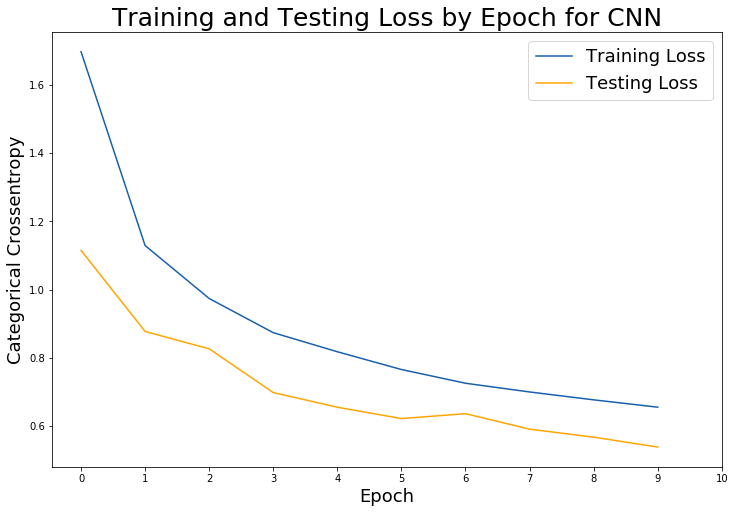

In [41]:
# Check out our train loss and test loss over epochs.

train_loss = history_conv.history['loss']

test_loss = history_conv.history['val_loss']

# Set figure size.

plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.

plt.plot(train_loss, label='Training Loss', color='#185fad')

plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title

plt.title('Training and Testing Loss by Epoch for CNN', fontsize = 25)

plt.xlabel('Epoch', fontsize = 18)

plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.legend(fontsize = 18)

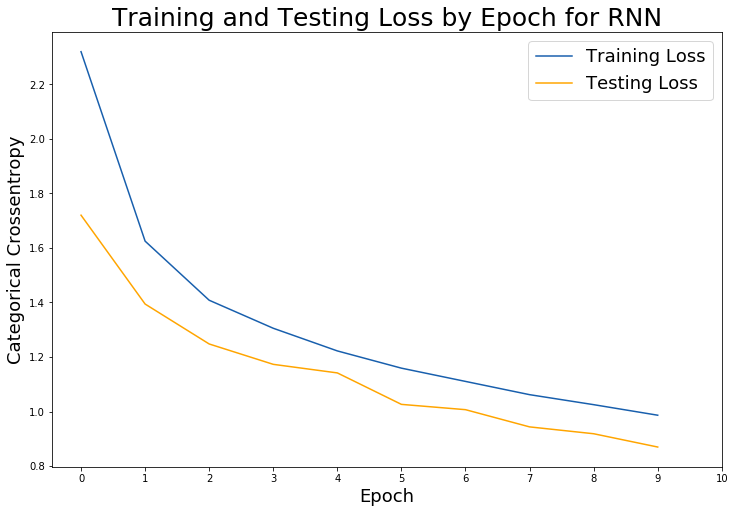

In [42]:
# # Check out our train loss and test loss over epochs.

train_loss = history_recurr.history['loss']

test_loss = history_recurr.history['val_loss']

# Set figure size.

plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.

plt.plot(train_loss, label='Training Loss', color='#185fad')

plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title

plt.title('Training and Testing Loss by Epoch for RNN', fontsize = 25)

plt.xlabel('Epoch', fontsize = 18)

plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.legend(fontsize = 18)

In [43]:
# Evaluate model on test data.

cnn_score = model_conv.evaluate(X_test_conv, y_test_conv, verbose=1)

cnn_labels = model_conv.metrics_names

recurr_score = model_recurr.evaluate(X_test_recurr, y_test_recurr, verbose=1)

recurr_labels = model_recurr.metrics_names

19797/19797 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 168us/step


In [44]:
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')

print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')

print(f'RNN {recurr_labels[0]}  : {recurr_score[0]}')

print(f'RNN {recurr_labels[1]}   : {recurr_score[1]}')

CNN loss  : 0.5579938300888412
CNN acc   : 0.8111329999555089
RNN loss  : 0.8925782524347727
RNN acc   : 0.7007122291527222


In [45]:
# Loading the best model

best_model = load_model("Best-models/best_conv.h5")

In [46]:
# Testing "test" dataset 

X_test_conv[21].shape

(3, 13, 1)

In [47]:
y_hat = best_model.predict(np.array([X_test_conv[21]]))

y_hat

array([[5.7587703e-09, 1.7111724e-06, 9.9872285e-01, 9.0393129e-05,
        1.0335630e-08, 1.1509744e-09, 1.5374773e-12, 7.6480945e-05,
        6.6754160e-06, 4.5731156e-08, 7.2047689e-05, 5.9925363e-04,
        2.9079763e-05, 1.4489564e-08, 3.1912964e-07, 1.1647588e-10,
        2.5843957e-07, 3.4057948e-09, 1.5881287e-12, 2.0735333e-05,
        2.3107172e-09, 1.8379012e-04, 1.9658564e-04, 5.5026823e-09]],
      dtype=float32)

In [48]:
y_pred = np.argmax(y_hat)

y_pred

2

In [49]:
classes[np.argmax(y_test_conv[21])] 

'A3#-3th'

In [50]:
classes[y_pred]

'A3#-3th'

In [51]:
np.array([X_test_conv[21]]).shape

(1, 3, 13, 1)